In [71]:
import starry
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import pymc3.math as pmm
import pymc3_ext as pmx
import exoplanet
from starry_process import StarryProcess, MCMCInterface
from starry_process.math import cho_factor, cho_solve
import starry_process 
import theano
import aesara_theano_fallback.tensor as tt
from theano.tensor.slinalg import cholesky
from corner import corner
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os
from tqdm import tqdm
from theano.tensor.random.utils import RandomStream
import scipy.linalg as sl
import scipy.stats as ss
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

starry.config.quiet = True
np.random.seed(1)

In [24]:
def _cho_solve(L, b):
    return tt.slinalg.solve_upper_triangular(L.T, tt.slinalg.solve_lower_triangular(L, b))

class StarryStarryProcess(object):
    def __init__(self, sys, sp, nt, nlm):
        self._sys = sys
        self._sp = sp
        self._nt = nt
        self._nlm = nlm

        self._mu = sp.mean_ylm
        self._Lambda = sp.cov_ylm

    @property
    def nt(self):
        return self._nt
    @property
    def nlm(self):
        return self._nlm

    @property
    def sys(self):
        return self._sys
    @property
    def sp(self):
        return self._sp
    
    @property
    def mu(self):
        return self._mu
    @property
    def Lambda(self):
        return self._Lambda
    
    @property
    def primary(self):
        return self.sys.primary
    @property
    def secondary(self):
        return self.sys.secondaries[0]
    
    @property
    def design_matrix(self):
        return self._M

    @property
    def logl_marginal(self):
        return self._logl_marginal
    @property
    def a(self):
        return self._a
    @property
    def AInv_chol(self):
        return self._AInv_chol

    def _compute(self, t, flux, sigma_flux):
        M = self.sys.design_matrix(t)[:,:-1] # We don't use any flux from the secondary, so [:, :-1]
        self._M = M

        nlm = self.nlm
        nt = self.nt

        mu = self.mu
        Lambda = self.Lambda

        # We want to enforce that the prior on the constant term in the map is
        # completely flat, so we set the first row and column of the precision
        # matrix to zero we do this manually here.  First we Cholesky decompose:
        #
        # Lambda[1:,1:] = L L^T
        #
        # Then, because of a quirk of theano (no gradients for `cho_solve!`,
        # WTF), we can compute Lambda[1:,1:]^{-1} via
        #
        # Lambda[1:,1:]^{-1} = tt.slinalg.solve_triangular(L.T, tt.slinalg.solve_triangular(L, tt.eye(nlm-1), lower=True), lower=False)
        #
        # encapsulated in our _cho_solve(...) function above
        L = tt.slinalg.cholesky(Lambda[1:,1:])
        Lambda_inv = _cho_solve(L, tt.eye(nlm-1))
        Lambda_inv = tt.set_subtensor(tt.zeros((nlm, nlm))[1:,1:], Lambda_inv)

        sigma_flux2 = tt.square(sigma_flux)
        MTCinv = M.T / sigma_flux2[None, :]
        MTCinvM = tt.dot(MTCinv, M)

        AInv = Lambda_inv + MTCinvM
        AInv_chol = tt.slinalg.cholesky(AInv)
        a = _cho_solve(AInv_chol, tt.dot(Lambda_inv, mu) + tt.dot(MTCinv, flux))

        self._a = a
        self._AInv_chol = AInv_chol

        b = tt.dot(M, mu)
        r = flux - b

        Cinvr = r / sigma_flux2

        rtilde = Cinvr - tt.dot(MTCinv.T, tt.slinalg.solve(AInv, tt.dot(MTCinv, r)))

        # Identity:
        # |B| = |I + M^T C^-1 M L| |C| = |L^-1 + M^T C^-1 M| |L| |C|
        # But we want to cancel the infinite constant in L[0,0], so we ignore the first row and column of L:
        # |B| = | A^-1 | |L[1:,1:]| |C|

        logdetB = tt.sum(tt.log(sigma_flux2)) + 2*tt.sum(tt.log(tt.diag(AInv_chol))) + 2*tt.sum(tt.log(tt.diag(L)))

        # (nt-1) because we have cancelled one dimension due to the flat prior on the [0,0] constant term.
        logl = -0.5*tt.dot(r, rtilde) - 0.5*logdetB - 0.5*(nt-1)*tt.log(2*np.pi)
        self._logl_marginal = logl

    def marginal_likelihood(self, t, flux, sigma_flux):
        self._compute(t, flux, sigma_flux)
        return self.logl_marginal
    
    def sample_ylm_conditional(self, t, flux, sigma_flux, size=1, rng=None):
        if rng is None:
            rng = RandomStream(seed=np.random.randint(1<<32))

        nylm = self.nlm

        self._compute(t, flux, sigma_flux)
        return self.a[None,:] + tt.slinalg.solve_upper_triangular(self.AInv_chol.T, rng.normal(size=(nylm, size))).T

## Helper Distribution functions

In [31]:
def Inclination(name, testval=30):
    """
    An isotropic distribution for inclination angles (in degrees).
    
    """
    def logp(x):
        return tt.log(np.pi / 180 * tt.sin(x * np.pi / 180))

    def random(*args, **kwargs):
        return tt.arccos(pm.Uniform.dist(0, 1).random(*args, **kwargs)) * 180 / np.pi

    return pm.DensityDist(
        name,
        logp,
        random=random,
        initval=testval,
    )


def Angle(*args, **kwargs):
    """
    A uniform distribution for angles in [-180, 180).
    
    """
    if kwargs.get("testval", None) is not None:
        kwargs["testval"] *= np.pi / 180
    return 180 / np.pi * pmx.Angle(*args, **kwargs)

def ori_xyz(name, testval):
    stellar_ori_x = pm.Normal(name+'_ori_x', mu=0, sigma=1, testval=testval)
    stellar_ori_y = pm.Normal(name+'_ori_y', mu=0, sigma=1, testval=testval)
    stellar_ori_z = pm.Normal(name+'_ori_z', mu=0, sigma=1, testval=testval)

    return stellar_ori_x, stellar_ori_y, stellar_ori_z

def Planet_Inc(name, *args, **kwargs):
    bmax = params[name].get('bmax')
    b = pm.Uniform('b', -bmax, bmax)
    planet_inc = pm.Deterministic(name, 180.0/np.pi*np.arccos(b))
    
    return planet_inc

def Stellar_Ang(name, *args, **kwargs):
    if kwargs.get("testval", None) is not None:
        trueval = kwargs["testval"]
    stellar_ori_x, stellar_ori_y, stellar_ori_z = ori_xyz(name, trueval)

    if "inc" in name:
        return pm.Deterministic(name, 180.0/np.pi*tt.arccos(stellar_ori_z / tt.sqrt(tt.square(stellar_ori_x) + tt.square(stellar_ori_y) + tt.square(stellar_ori_z))))
    
    elif "obl" in name:
        return pm.Deterministic(name, 180.0/np.pi*tt.arctan2(stellar_ori_y, stellar_ori_x))

def Period(name, *args, **kwargs):
    Ttotal = t[-1] - t[0]
    frac_bounds = params[name].get('frac_bounds')

    if kwargs.get("testval", None) is not None:
        trueval = kwargs["testval"]

    def logp(trueval, frac_bounds):
        return pm.Uniform(name+'logp',tt.log(trueval) + np.log1p(-frac_bounds), tt.log(trueval) + np.log1p(frac_bounds))

    period = pm.Deterministic(name, tt.exp(logp(trueval, frac_bounds)))

    return period

def Logarithmic(name, *args, **kwargs):
    if kwargs.get("testval", None) is not None:
        trueval = kwargs["testval"]
    log_rp = pm.Uniform(name+'log', tt.log(trueval/2), tt.log(2*trueval))
    rp = pm.Deterministic(name, tt.exp(log_rp))

    return rp

# Shorthand for the usual Uniform distribution
Uniform = pm.Uniform

In [45]:
def generate(t, params, nt, error=1e-4, visualize=True):
    """
    Generate a synthetic light curve.
    
    """
    rng = np.random.default_rng(302592346730275158208684369480422136411)
    # Set up the system
    map = starry.Map(15, 2)
    map.inc = params["star.inc"]["truth"]
    map.obl = params["star.obl"]["truth"]
    map[1] = params["star.u1"]["truth"]
    map[2] = params["star.u2"]["truth"]
    star = starry.Primary(map, r=params["star.r"]["truth"], m=params["star.m"]["truth"], prot=params["star.prot"]["truth"]) 
    planet = starry.Secondary(
        starry.Map(0,0),
        inc=params["planet.inc"]["truth"],
        ecc=params["planet.ecc"]["truth"],
        Omega=params["planet.Omega"]["truth"],
        porb=params["planet.porb"]["truth"],
        t0=params["planet.t0"]["truth"],
        r=params["planet.r"]["truth"],
        m=params["planet.m"]["truth"],
        prot=1.0
    )

    sys = starry.System(star, planet)
    xo, yo, zo = sys.position(t)
    xo = xo.eval()[1]
    yo = yo.eval()[1]
    zo = zo.eval()[1]
    theta = (360 * t / params["star.prot"]["truth"]) % 360
    
    # *** Draw 1 sample from the GP
    sp = StarryProcess(
        mu=params["gp.mu"]["truth"],
        sigma=params["gp.sigma"]["truth"],
        r=params["gp.r"]["truth"],
        dr=params["gp.dr"]["truth"],
        c=params["gp.c"]["truth"],
        n=params["gp.n"]["truth"],
    )

    nt = len(t)
    ssp = StarryStarryProcess(sys, sp, nt, 256)
    
    y_true = sp.sample_ylm().eval().reshape(-1)
    y_true[0] += 1
    
    # Compute the light curve
    flux_true = sys.design_matrix(t).eval()[:, :-1] @ y_true
    sigma_flux = error*np.ones_like(flux_true)

    flux_obs = flux_true + sigma_flux*rng.normal(size=nt)

    star.map[:,:] = y_true

    
    # Visualize the system
    if visualize:
        fig, ax = plt.subplots(1, 2, figsize=(20, 8))
        idx = (zo > 0) | (xo ** 2 + yo ** 2 > 1)
        ax[0].plot(xo[idx], yo[idx], "k.", ms=1);
        ax[0].set_aspect(1)
        ax[0].axis("off")
        map[:, :] = y_true
        map.show(ax=ax[0])
        ax[0].set_ylim(-3, 3)
        idx = (zo > 0) & (xo ** 2 + yo ** 2 < 1)
        lat = 180 / np.pi * np.arcsin(yo[idx])
        lon = 180 / np.pi * np.arcsin(xo[idx] / np.sqrt(1 - yo[idx] ** 2)) - theta[idx]
        lon = (lon + 180) % 360 - 180
        mask = np.append(np.array(lon[1:] > lon[:-1], dtype=float), 0)
        mask[mask == 1] = np.nan
        map.show(ax=ax[1], projection="rect")
        ax[1].plot(lon, lat + mask, "k-");
    
    return flux_obs, flux_true, sigma_flux, ssp, sp, y_true, sys

In [46]:
def gp_model(t, flux, err, params):

    # Helper function to instantiate parameters
    def parameter(name):
        param = params[name]
        if param.get("free", False):
            args = param.get("args", [])
            kwargs = param.get("kwargs", {})
            testval = param.get("testval", param["truth"])
            return param["dist"](name, *args, testval=testval, **kwargs)
            
        else:
            return param["truth"]
    
    
    starry.config.lazy = True
    
    with pm.Model() as model:

        prot = parameter('star.prot')
        stellar_inc = parameter('star.inc')
        stellar_obl = parameter('star.obl')

        porb = parameter('planet.porb')
        t0 = parameter('planet.t0')
        rp = parameter('planet.r')
        planet_inc = parameter('planet.inc')
        mp = parameter('planet.m')
        ecc = parameter('planet.ecc')
        Omega = parameter('planet.Omega')

        pri_model = starry.Primary(starry.Map(ydeg=15, udeg=2, inc=stellar_inc, obl=stellar_obl), 
            r=parameter('star.r'), 
            m=parameter('star.m'), 
            prot=prot, 
            t0=0.0)
        pri_model.map[1] = parameter('star.u1')
        pri_model.map[2] = parameter('star.u2')

        sec_model = starry.Secondary(starry.Map(0,0), 
            t0=t0, 
            r=rp, 
            m=mp, 
            prot=1,
            porb=porb, 
            ecc=ecc, 
            Omega=Omega, 
            inc=planet_inc)
    
        sys_model = starry.System(pri_model, sec_model)

        # Instantiate the GP
        sp_model = StarryProcess(
            mu=parameter("gp.mu"),
            sigma=parameter("gp.sigma"),
            r=parameter("gp.r"),
            dr=parameter("gp.dr"),
            c=parameter("gp.c"),
            n=parameter("gp.n"),
            ydeg=15,
            udeg=2,
            marginalize_over_inclination=False,  
        )

        ssp_model = StarryStarryProcess(sys_model, sp_model, len(t), 256)

        pm.Potential('marginal_likelihood', ssp_model.marginal_likelihood(t, flux, err))
        
        return model

## Generate a light curve

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


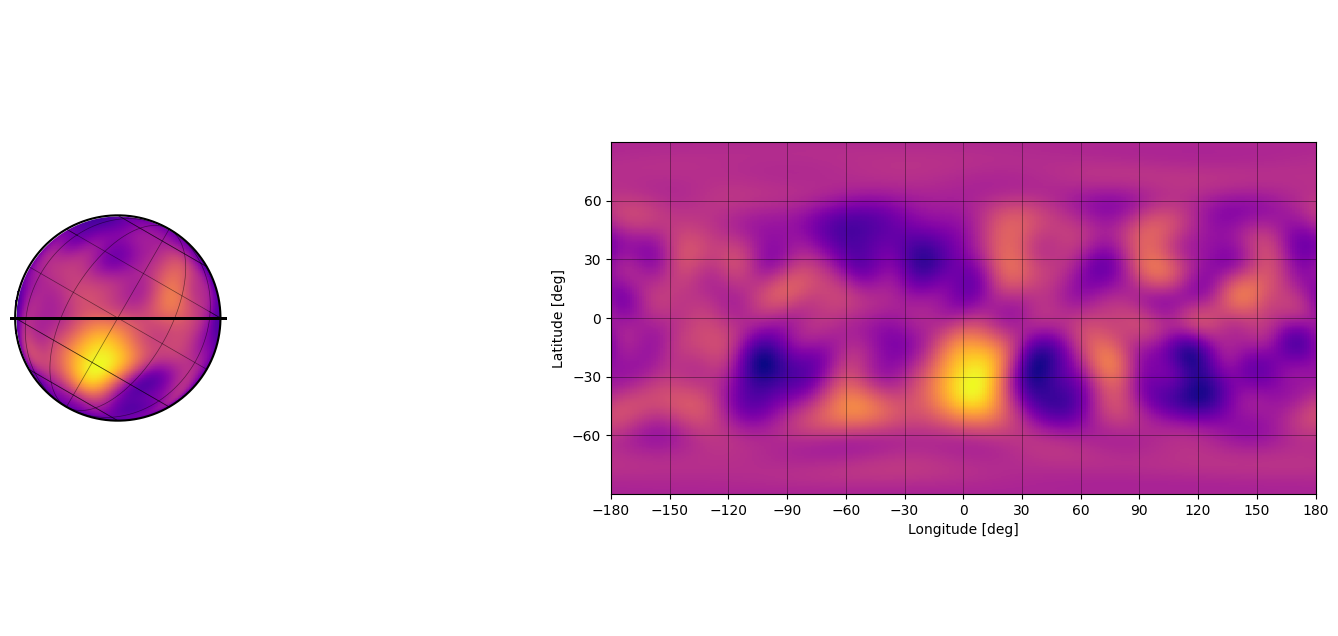

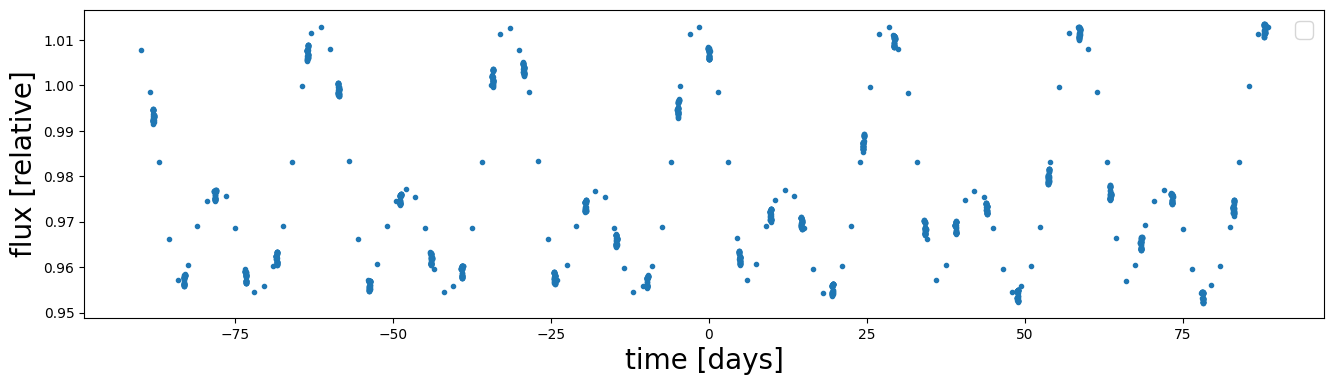

In [47]:
# True parameters & priors
params = {
    "planet.inc": {"truth": 90.0, "dist": Planet_Inc},
    "planet.ecc": {"truth": 0.0, "dist": Uniform, "args": [0.0, 0.4]},
    "planet.Omega": {"truth": 0.0, "dist": Angle},
    "planet.porb": {"truth": 4.887802443, "dist": Period},
    "planet.t0": {"truth": 0.0, "dist": Uniform, "args": [-0.2, 0.2]},
    "planet.r": {"truth": 0.04*0.683, "dist": Logarithmic},
    "planet.m": {"truth": 1e-3*0.81, "dist": Uniform, "args": [0.0001, 0.001]},

    "star.inc": {"truth": 90, "dist": Stellar_Ang},
    "star.m": {"truth": 0.81, "dist": Uniform, "args": [0.4, 1]},
    "star.u1": {"truth": 0.4, "dist": Uniform, "args": [0.0, 0.6]},
    "star.u2": {"truth": 0.26, "dist": Uniform, "args": [0.0, 0.4]},
    "star.prot": {"truth": 30, "dist": Period},
    "star.obl": {"truth": -30.0, "dist": Stellar_Ang},
    "star.r": {"truth": 0.683, "dist": Uniform, "args": [0.1, 1]},

    "gp.r": {"truth": 20, "dist": Uniform, "args": [5.0, 25.0]},
    "gp.dr": {"truth": 5.0, "dist": Uniform, "args": [1.0, 10.0]},
    "gp.c": {"truth": 0.5, "dist": Uniform, "args": [0.01, 1]},
    "gp.n": {"truth": 1, "dist": Uniform, "args": [0, 10]},
    "gp.mu": {"truth": 30, "dist": Uniform, "args": [0.0, 80.0]},
    "gp.sigma": {"truth": 5, "dist": Uniform, "args": [1.0, 10]}
}

# Initializing the time
Ttr_half = 0.1
dt_in_transit = Ttr_half / 20.0
dt_out_transit = params['star.prot']['truth'] / 20.0

T = 3*params['star.prot']['truth']
t_in = np.arange(-T, T, dt_in_transit)
t_out = np.arange(-T, T, dt_out_transit)

t_in_transit = (t_in % params['planet.porb']['truth'] < Ttr_half) | (t_in % params['planet.porb']['truth'] > params['planet.porb']['truth']-Ttr_half)
t_out_transit = (t_out % params['planet.porb']['truth'] < Ttr_half) | (t_out % params['planet.porb']['truth'] > params['planet.porb']['truth']-Ttr_half)

t = np.sort(np.concatenate((
    t_in[t_in_transit],
    t_out[~t_out_transit],
)))
nt = len(t)

Ttotal = t[-1] - t[0]

# Setting the priors
# fraction bounds for period priors
prot_frac_bounds = min(params['star.prot']['truth']/Ttotal/2, 0.25)
porb_frac_bounds = min(params['planet.porb']['truth']/Ttotal/2, 0.25)

# Let's add this parameter to the parameter dictionary as a prior
params['star.prot']['frac_bounds'] = prot_frac_bounds
params['planet.porb']['frac_bounds'] = porb_frac_bounds

# semi-major axis
a = (params['star.m']['truth']*np.square(params['planet.porb']['truth']/365.25))**(1/3) * 215.03 # Solar radii
# impact parameter
bmax = params['star.r']['truth'] / a

# Let's add this parameter to the parameter dictionary as a prior
params['planet.inc']['bmax'] = bmax

# Get the light curve
flux_obs, flux_true, sigma_flux, ssp, sp, y_true, sys_true = generate(t, params, nt=nt, error=1e-4)

# Plot the data
fig, ax = plt.subplots(1, figsize=(16, 4))
ax.errorbar(t, flux_obs, yerr=sigma_flux, fmt='.')
ax.set_ylabel("flux [relative]", fontsize=20)
ax.set_xlabel("time [days]", fontsize=20)
ax.legend(fontsize=16);

<ErrorbarContainer object of 3 artists>

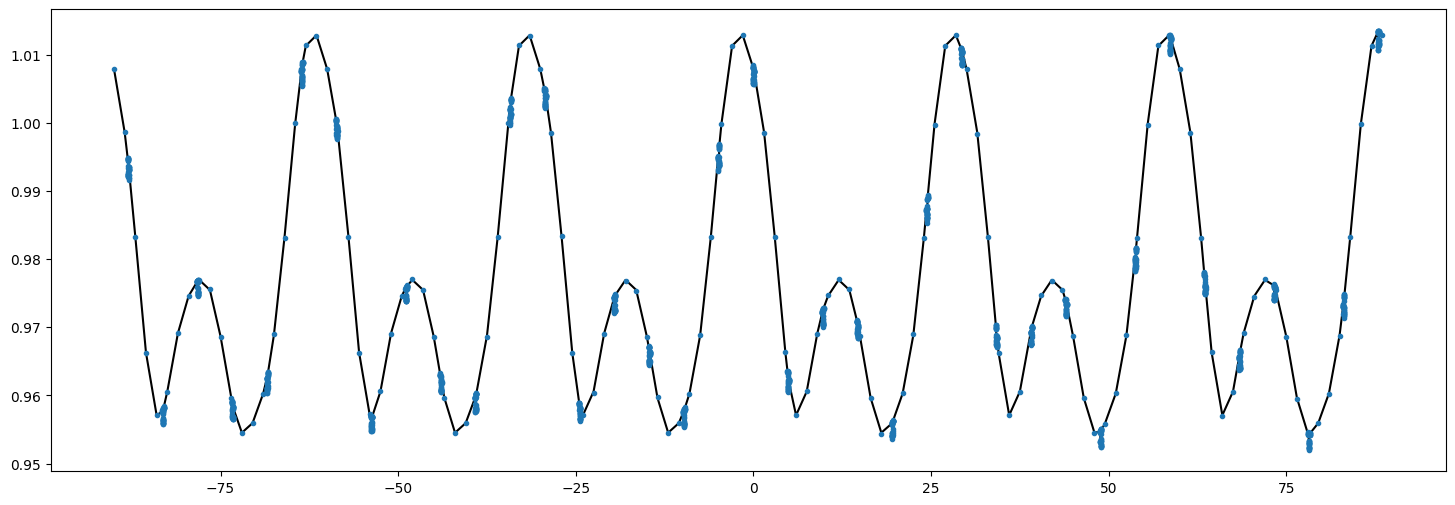

In [48]:
plt.figure(figsize=(18,6))
plt.plot(t, flux_true, color='k')
plt.errorbar(t, flux_obs, yerr=sigma_flux, fmt='.')

/Users/sabina/Desktop/GitHub/starry_process/starry_process/visualize.py:118: RuntimeWarning: invalid value encountered in true_divide
  theta -= (2 * theta + np.sin(2 * theta) - np.pi * np.sin(lat)) / (


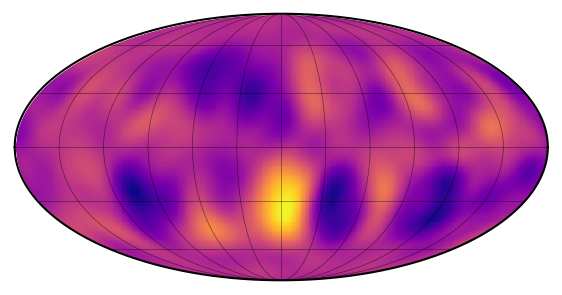

In [49]:
sp.visualize(y_true)

<ErrorbarContainer object of 3 artists>

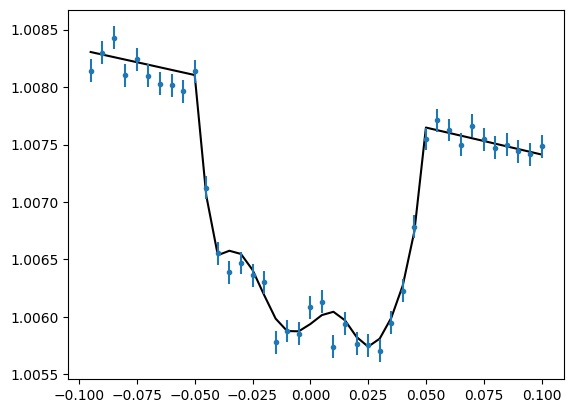

In [50]:
sel = np.abs(t) < 1/10
plt.plot(t[sel], flux_true[sel], color='k')
plt.errorbar(t[sel], flux_obs[sel], yerr=sigma_flux[sel], fmt='.')

In [51]:
ylm_draw = ssp.sample_ylm_conditional(t, flux_obs, sigma_flux).eval()[0,:]

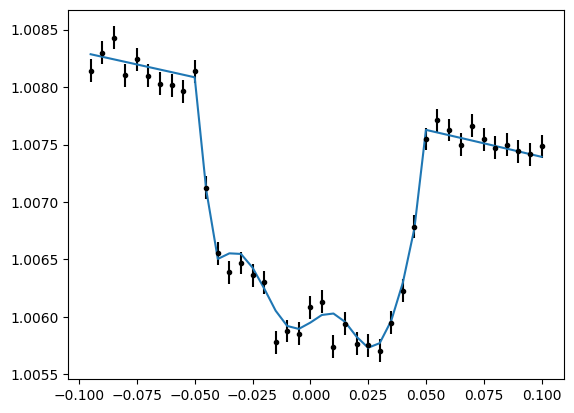

In [52]:
plt.errorbar(t[sel], flux_obs[sel], yerr=sigma_flux[sel], fmt='.', color='k')
plt.plot(t[sel], (ssp.design_matrix.eval() @ ssp.a.eval())[sel])

/Users/sabina/Desktop/GitHub/starry_process/starry_process/visualize.py:118: RuntimeWarning: invalid value encountered in true_divide
  theta -= (2 * theta + np.sin(2 * theta) - np.pi * np.sin(lat)) / (


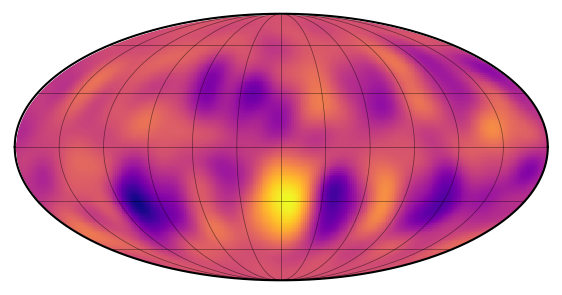

In [53]:
sp.visualize(ylm_draw)

In [15]:
resid = flux_obs - ssp.design_matrix.eval() @ ylm_draw
np.sum(ss.norm(loc=0, scale=sigma_flux).logpdf(resid)) - 0.5*np.dot(ylm_draw[1:] - sp.mean_ylm.eval()[1:], np.linalg.solve(sp.cov_ylm.eval()[1:,1:], ylm_draw[1:] - sp.mean_ylm.eval()[1:])) - 0.5*np.linalg.slogdet(sp.cov_ylm.eval()[1:,1:])[1] - 0.5*(len(ylm_draw)-1)*np.log(2*np.pi)

13599.716787808335

In [16]:
whitened_ylm_resid = np.dot(ssp.AInv_chol.T.eval(), ylm_draw - ssp.a.eval())
ssp.marginal_likelihood(t, flux_obs, sigma_flux).eval() - 0.5*np.dot(whitened_ylm_resid, whitened_ylm_resid) + np.sum(np.log(np.diag(ssp.AInv_chol.eval()))) - 0.5*len(ylm_draw)*np.log(2*np.pi)

13599.716828178713

In [17]:
ssp.marginal_likelihood(t, flux_obs, sigma_flux).eval()

array(12245.33202028)

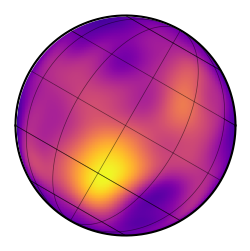

In [54]:
map_true = starry.Map(15, udeg=2)
map_true.inc = params["star.inc"]["truth"]
map_true.obl = params["star.obl"]["truth"]
map_true[1] = params["star.u1"]["truth"]
map_true[2] = params["star.u2"]["truth"]
map_true[:,:] = y_true
map_true.show()

In [55]:
sys_true.show(t[::2])

# Inference

In [56]:
# Set some free params & get the model
p = dict(params)

p['star.prot']['free'] = True
p['star.obl']['free'] = True
p['star.inc']['free'] = True

p['planet.porb']['free'] = True
p['planet.t0']['free'] = True
p['planet.r']['free'] = True
p['planet.inc']['free'] = True

p['gp.c']['free'] = True
p['gp.mu']['free'] = True
p['gp.sigma']['free'] = True
p['gp.r']['free'] = True
p['gp.n']['free'] = True

free = [x for x in p.keys() if p[x].get("free", False)]
model = gp_model(t, flux_obs, sigma_flux, p)

In [57]:
free

['planet.inc',
 'planet.porb',
 'planet.t0',
 'planet.r',
 'star.inc',
 'star.prot',
 'star.obl',
 'gp.r',
 'gp.c',
 'gp.n',
 'gp.mu',
 'gp.sigma']

In [58]:
# Optimize
with model:
    map_soln = pmx.optimize()
    for x in free:
        print(f"{x}: {map_soln[x]} {[params[x]['truth']]}")

optimizing logp for variables: [gp.n, gp.c, gp.r, gp.sigma, gp.mu, b, planet.rlog, planet.t0, planet.porblogp, star.obl_ori_z, star.obl_ori_y, star.obl_ori_x, star.inc_ori_z, star.inc_ori_y, star.inc_ori_x, star.protlogp]



planet.inc: 89.96912603397658 [90.0]
planet.porb: 4.887804049023348 [4.887802443]
planet.t0: -1.7879657521993608e-05 [0.0]
planet.r: 0.027239657331327306 [0.027320000000000004]
star.inc: 89.61604926349322 [90]
star.prot: 29.999183869894075 [30]
star.obl: -30.58753469114805 [-30.0]
gp.r: 19.722897799556254 [20]
gp.c: 0.44929081519053715 [0.5]
gp.n: 1.062745825083928 [1]
gp.mu: 29.50938441891474 [30]
gp.sigma: 4.356778289961626 [5]


message: Desired error not necessarily achieved due to precision loss.
logp: -22817.17460119493 -> 12228.604069297871


In [59]:
with model:
    trace = pmx.sample(
        tune=1000,
        draws=1000,
        start=map_soln,
        chains=1,
        cores=4,
        target_accept=0.9,
        return_inferencedata=False,
    )

Sequential sampling (1 chains in 1 job)
NUTS: [gp.n, gp.c, gp.r, gp.sigma, gp.mu, b, planet.rlog, planet.t0, planet.porblogp, star.obl_ori_z, star.obl_ori_y, star.obl_ori_x, star.inc_ori_z, star.inc_ori_y, star.inc_ori_x, star.protlogp]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 29933 seconds.
There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


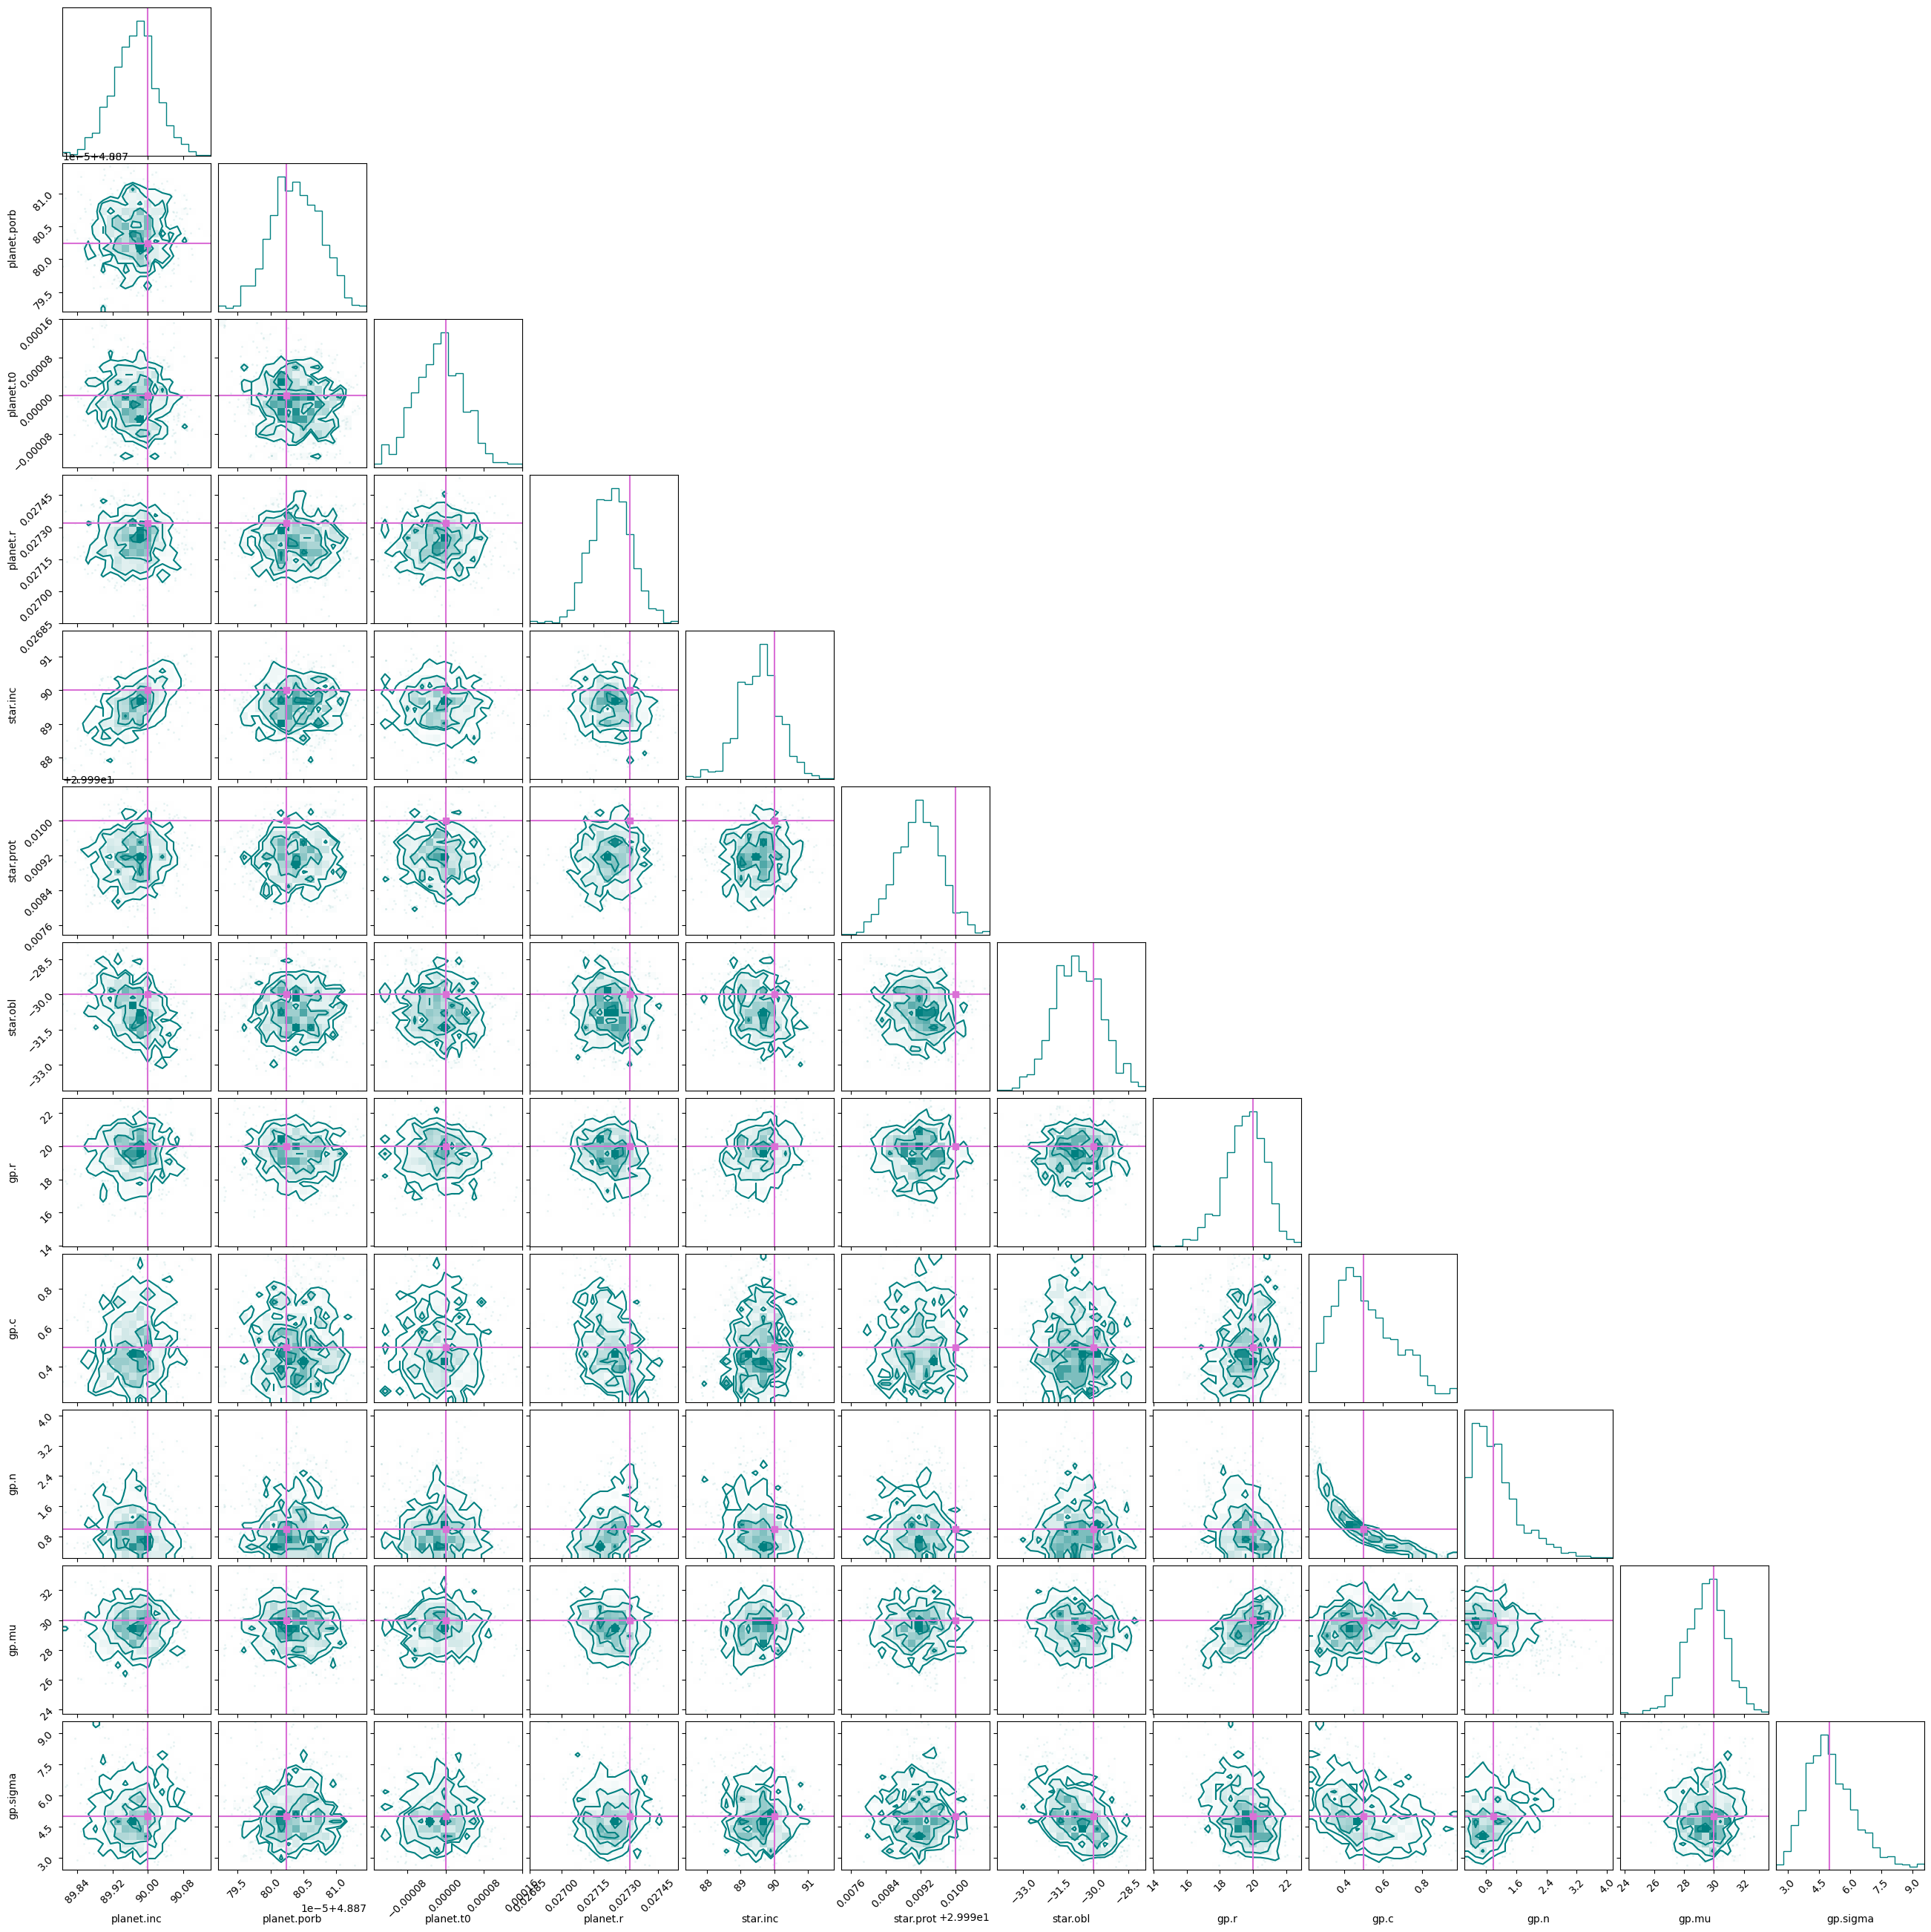

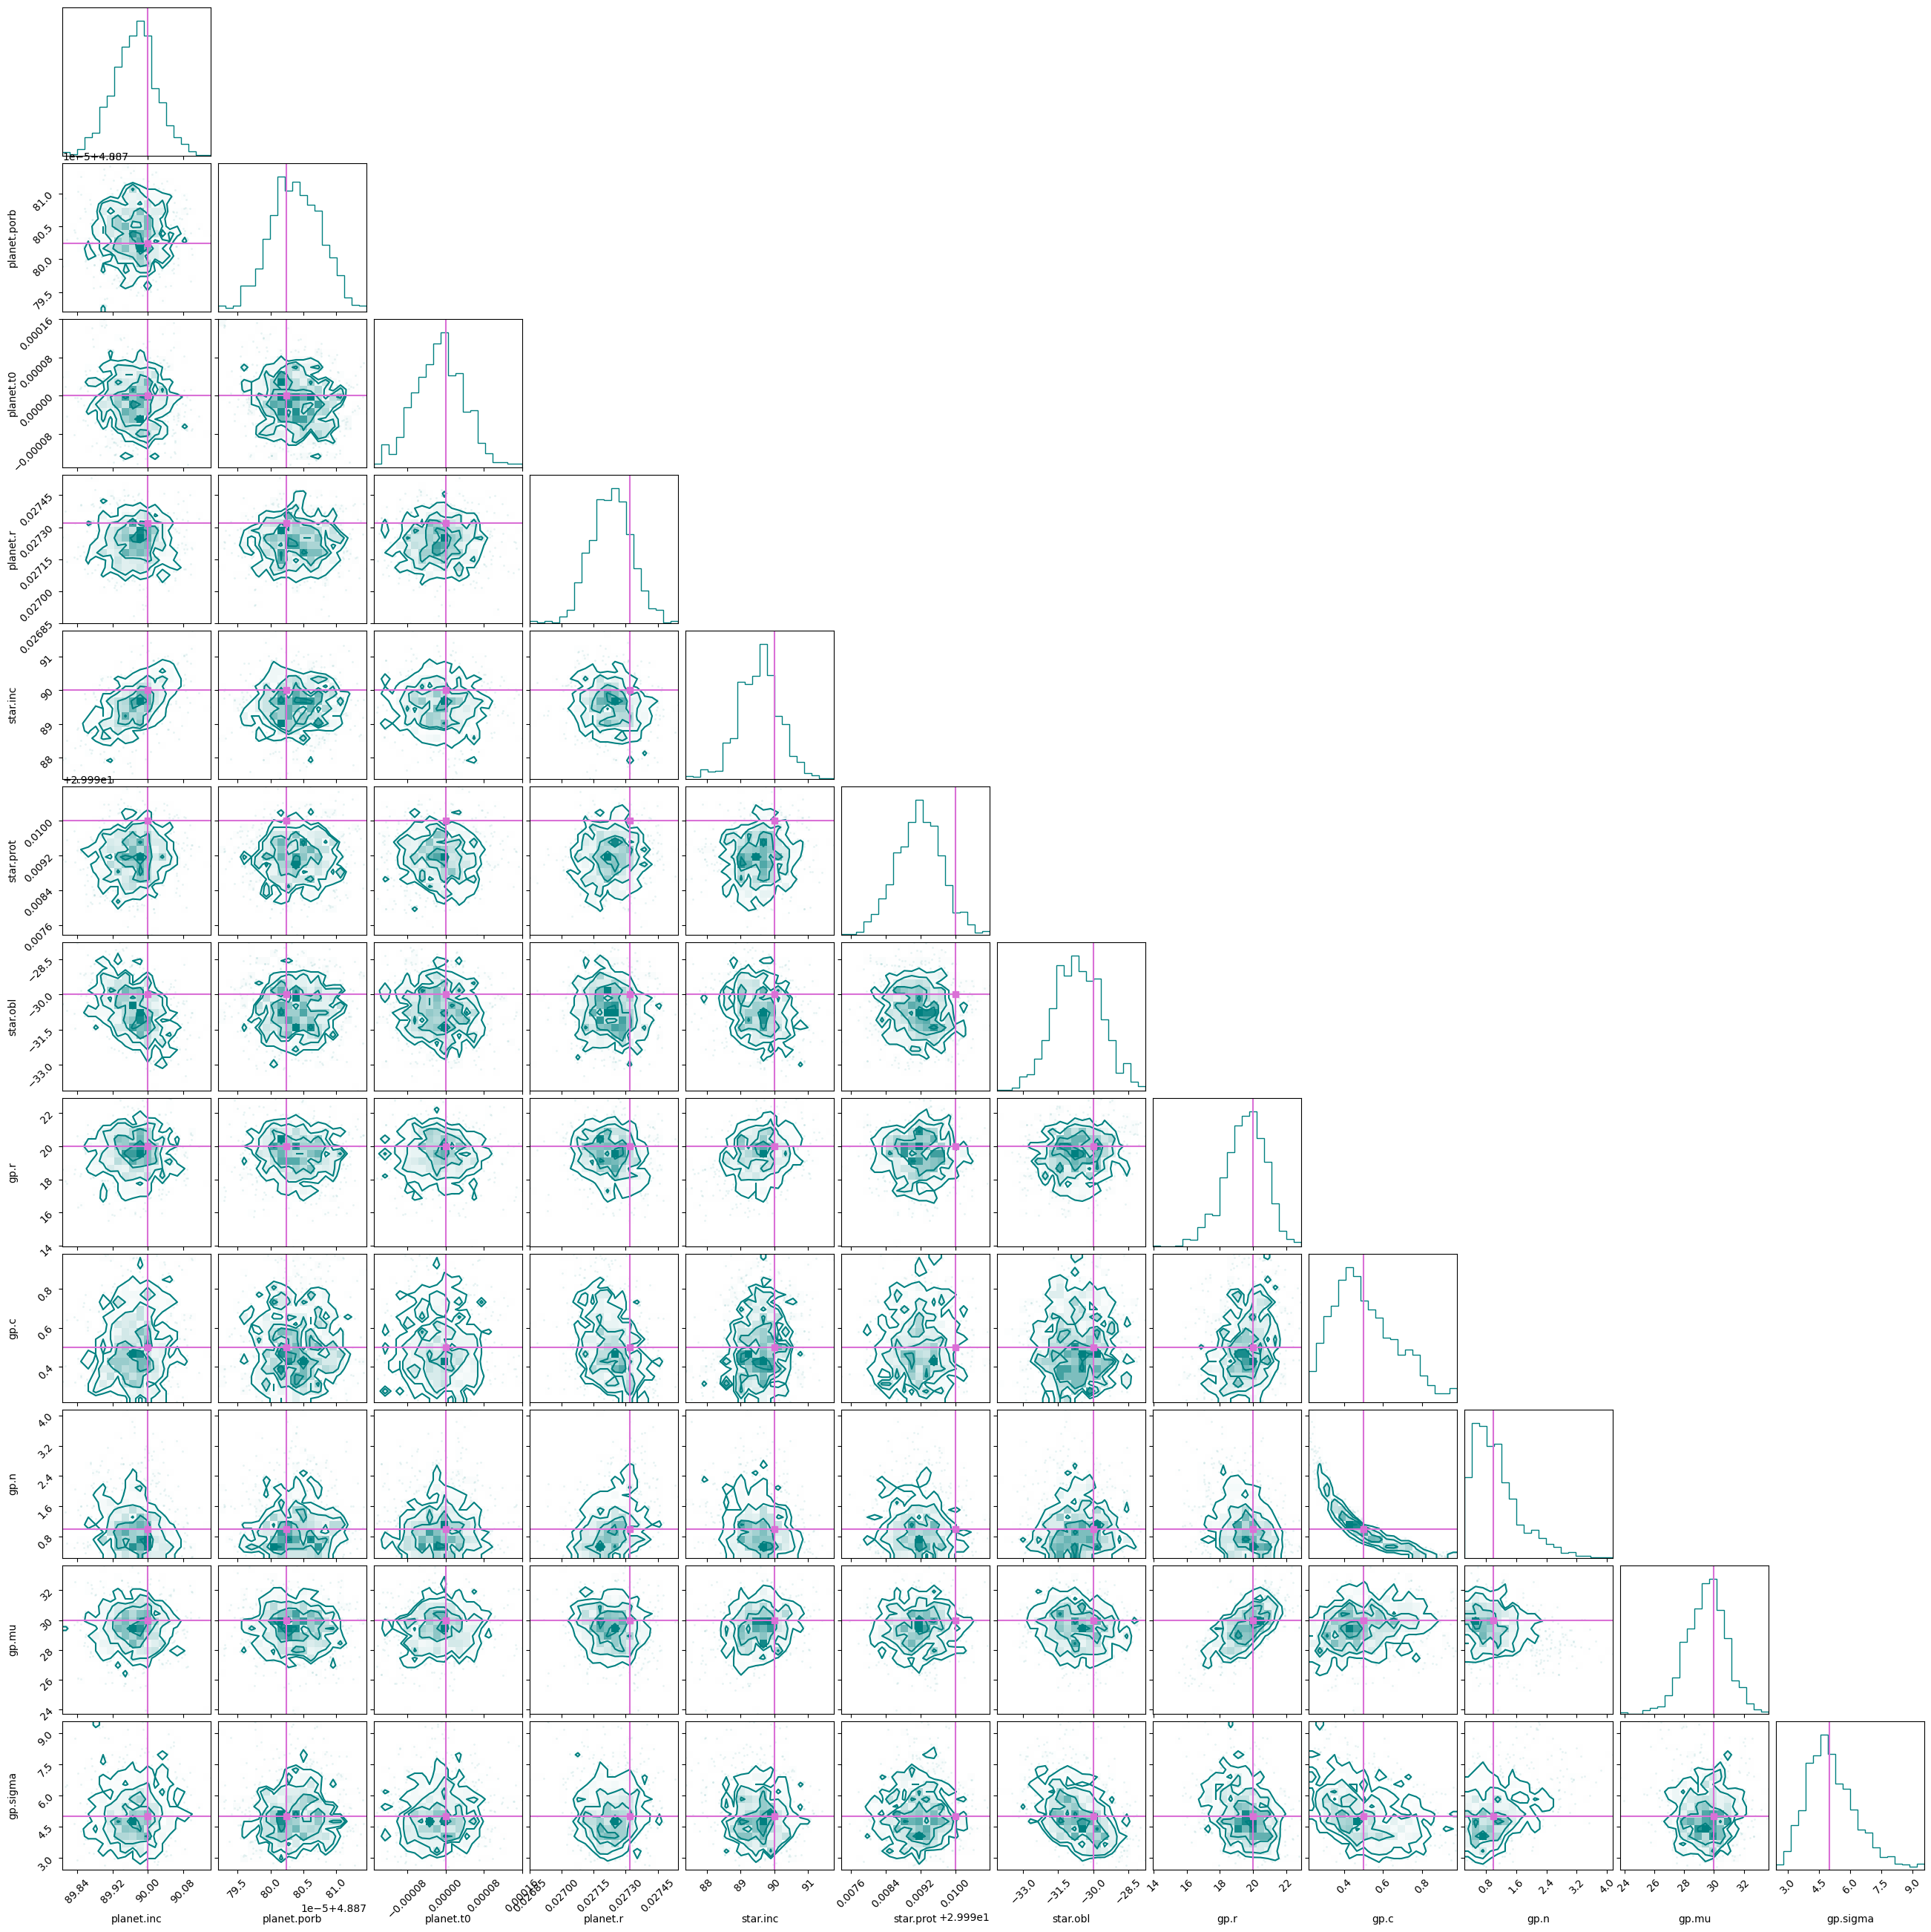

In [67]:
samples = pm.trace_to_dataframe(trace,varnames=free)
corner(np.array(samples),labels=free,truths=[params[x]['truth'] for x in free], color='teal', truth_color='orchid')

### let's save our trace

In [61]:
az.to_netcdf(trace,'SSP-organized-planet-star-gp.nc')

Got error No model on context stack. trying to find log_likelihood in translation.
/opt/anaconda3/envs/starry-test/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


'SSP-organized-planet-star-gp.nc'

In [63]:
# the summary
az.summary(trace)

Got error No model on context stack. trying to find log_likelihood in translation.
/opt/anaconda3/envs/starry-test/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
star.inc_ori_x    0.123  1.220  -2.184    2.181      0.071    0.050     301.0   
star.inc_ori_y   -0.069  1.215  -2.155    2.106      0.060    0.043     415.0   
star.inc_ori_z    0.013  0.021  -0.026    0.051      0.001    0.001     442.0   
star.obl_ori_x    1.085  0.514   0.164    1.941      0.040    0.029     157.0   
star.obl_ori_y   -0.643  0.304  -1.170   -0.112      0.023    0.016     166.0   
star.obl_ori_z   -0.043  0.950  -1.849    1.715      0.037    0.033     662.0   
star.protlogp     3.401  0.000   3.401    3.401      0.000    0.000     635.0   
star.prot        29.999  0.001  29.998   30.000      0.000    0.000     635.0   
star.inc         89.542  0.624  88.494   90.842      0.026    0.018     611.0   
star.obl        -30.668  1.020 -32.368  -28.553      0.040    0.028     649.0   
planet.porblogp   1.587  0.000   1.587    1.587      0.000    0.000     696.0   
planet.porb       4.888  0.000   4.888    4.888      0.000    0.000     696.0   
planet.t0        -0.000  0.000  -0.000    0.000      0.000    0.000     621.0   
planet.rlog      -3.603  0.003  -3.610   -3.597      0.000    0.000     529.0   
planet.r          0.027  0.000   0.027    0.027      0.000    0.000     529.0   
b                 0.001  0.001  -0.001    0.002      0.000    0.000     672.0   
planet.inc       89.970  0.050  89.875   90.066      0.002    0.001     672.0   
gp.mu            29.483  1.340  27.073   32.062      0.054    0.038     633.0   
gp.sigma          5.105  1.219   2.951    7.334      0.064    0.048     396.0   
gp.r             19.497  1.236  16.932   21.442      0.051    0.037     557.0   
gp.c              0.509  0.163   0.237    0.805      0.015    0.011     139.0   
gp.n              1.105  0.640   0.241    2.283      0.047    0.033     146.0   

                 ess_tail  r_hat  
star.inc_ori_x      446.0    NaN  
star.inc_ori_y      579.0    NaN  
star.inc_ori_z      373.0    NaN  
star.obl_ori_x      346.0    NaN  
star.obl_ori_y      332.0    NaN  
star.obl_ori_z      585.0    NaN  
star.protlogp       561.0    NaN  
star.prot           561.0    NaN  
star.inc            452.0    NaN  
star.obl            664.0    NaN  
planet.porblogp     496.0    NaN  
planet.porb         496.0    NaN  
planet.t0           595.0    NaN  
planet.rlog         689.0    NaN  
planet.r            689.0    NaN  
b                   577.0    NaN  
planet.inc          577.0    NaN  
gp.mu               439.0    NaN  
gp.sigma            398.0    NaN  
gp.r                423.0    NaN  
gp.c                144.0    NaN  
gp.n                238.0    NaN

### now, let's work with the samples from the file

In [68]:
samples_fromfile = az.from_netcdf('SSP-organized-planet-star-gp.nc')

In [69]:
samples = samples_fromfile.posterior.to_dataframe()

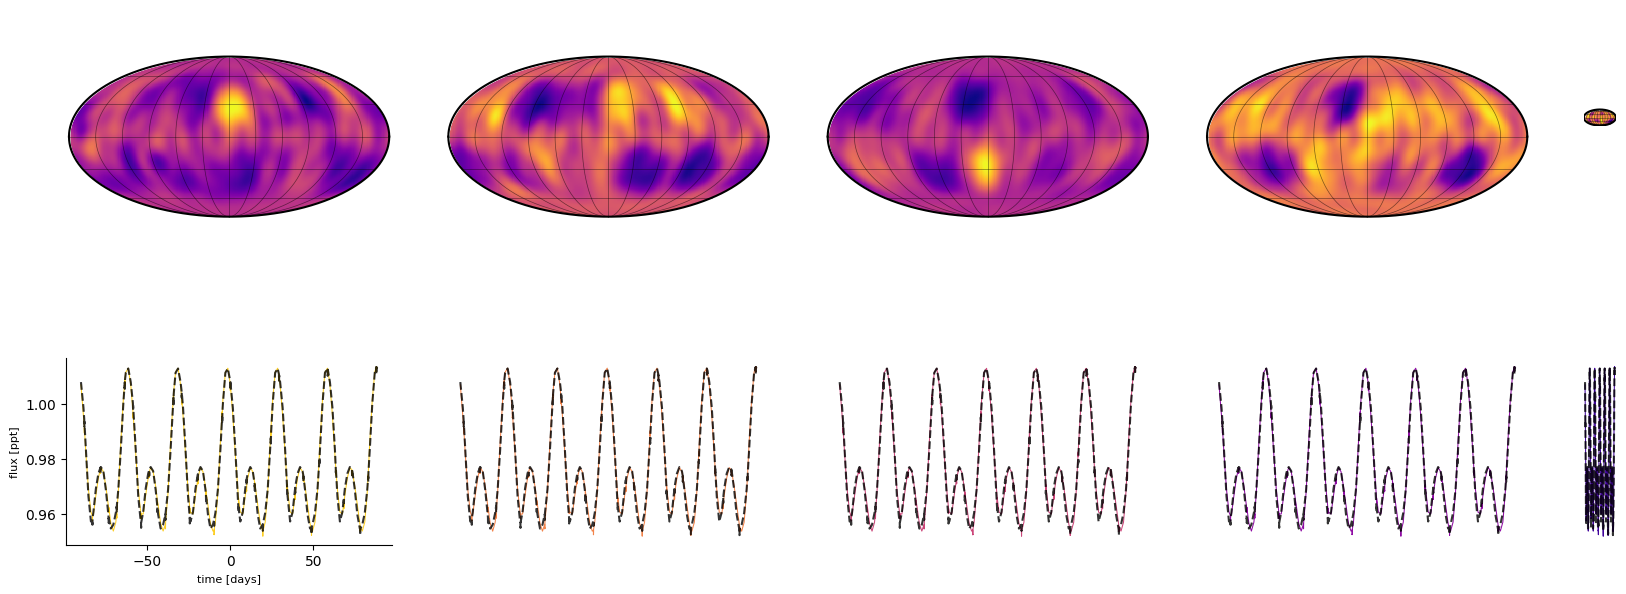

In [96]:
# plotting 5 samples
nsamples = 5
norm = Normalize(vmin=0.5, vmax=1.1)
cmap = plt.get_cmap("plasma_r")
color = lambda i: cmap(0.1 + 0.8 * i / (nsamples - 1))


fig, ax = plt.subplots(
    2,
    nsamples,
    figsize=(20, 8),
    gridspec_kw={
        "height_ratios": np.tile([1, 0.5], 1),
        "width_ratios": np.append(np.ones(nsamples-1), 0.1),
    },
)

for k in range(nsamples):
    # get a random sample from the posterior distributions
    rand_index = np.random.randint(0,samples.shape[0])
    map_samples = starry.Map(15, 2)
    star = starry.Primary(map_samples, r=params["star.r"]["truth"], m=params["star.m"]["truth"], prot=samples["star.prot"][0][rand_index]) 
    planet = starry.Secondary(
        starry.Map(0,0),
        inc=samples["planet.inc"][0][rand_index],
        ecc=params["planet.ecc"]["truth"],
        Omega=params["planet.Omega"]["truth"],
        porb=samples["planet.porb"][0][rand_index],
        t0=samples["planet.t0"][0][rand_index],
        r=samples["planet.r"][0][rand_index],
        m=params["planet.m"]["truth"],
        prot=1.0
    )

    sys = starry.System(star, planet)
    xo, yo, zo = sys.position(t)
    xo = xo.eval()[1]
    yo = yo.eval()[1]
    zo = zo.eval()[1]
    theta = (360 * t / params["star.prot"]["truth"]) % 360
    
    sp_samples = StarryProcess(
        mu=samples["gp.mu"][0][rand_index],
        sigma=samples["gp.sigma"][0][rand_index],
        r=samples["gp.r"][0][rand_index],
        dr=params["gp.dr"]["truth"],
        c=samples["gp.c"][0][rand_index],
        n=samples["gp.n"][0][rand_index],
    )

    nt = len(t)
    ssp_samples = StarryStarryProcess(sys, sp_samples, nt, len(star.map.y.eval()))

    ylm_samples = ssp_samples.sample_ylm_conditional(t, flux_obs, sigma_flux).eval()[0,:]

    map_samples[:, :] = ylm_samples.reshape(-1)
    map_samples.show(ax=ax[0, k], projection="moll")
    ax[0, k].set_ylim(-1.5, 2.25)
    ax[0, k].set_rasterization_zorder(1)
    flux_samples = sys.design_matrix(t).eval()[:, :-1] @ ylm_samples
    ax[1, k].plot(t, flux_samples, color=color(k), lw=0.75, alpha=1)
    ax[1, k].plot(t, flux_true, 'k--', alpha=0.8)

    if k == 0:
        ax[1, k].spines["top"].set_visible(False)
        ax[1, k].spines["right"].set_visible(False)
        ax[1, k].set_xlabel("time [days]", fontsize=8)
        ax[1, k].set_ylabel("flux [ppt]", fontsize=8)
    else:
        ax[1, k].axis("off")


### get 100 samples and save them

In [79]:
nsamples = 100
sampled_ylms = []
for k in range(nsamples):
    filename = 'ssp-samples' + str(k)
    rand_index = np.random.randint(0,samples.shape[0])
    map_samples = starry.Map(15, 2)
    star = starry.Primary(map_samples, r=params["star.r"]["truth"], m=params["star.m"]["truth"], prot=samples["star.prot"][0][rand_index]) 
    planet = starry.Secondary(
        starry.Map(0,0),
        inc=samples["planet.inc"][0][rand_index],
        ecc=params["planet.ecc"]["truth"],
        Omega=params["planet.Omega"]["truth"],
        porb=samples["planet.porb"][0][rand_index],
        t0=samples["planet.t0"][0][rand_index],
        r=samples["planet.r"][0][rand_index],
        m=params["planet.m"]["truth"],
        prot=1.0
    )

    sys = starry.System(star, planet)
    xo, yo, zo = sys.position(t)
    xo = xo.eval()[1]
    yo = yo.eval()[1]
    zo = zo.eval()[1]
    theta = (360 * t / params["star.prot"]["truth"]) % 360
    
    sp_samples = StarryProcess(
        mu=samples["gp.mu"][0][rand_index],
        sigma=samples["gp.sigma"][0][rand_index],
        r=samples["gp.r"][0][rand_index],
        dr=params["gp.dr"]["truth"],
        c=samples["gp.c"][0][rand_index],
        n=samples["gp.n"][0][rand_index],
    )

    nt = len(t)
    ssp_samples = StarryStarryProcess(sys, sp_samples, nt, len(star.map.y.eval()))

    ylm_samples = ssp_samples.sample_ylm_conditional(t, flux_obs, sigma_flux).eval()[0,:]
    sampled_ylms.append(ylm_samples)

    map_samples[:, :] = ylm_samples.reshape(-1)
    map_samples.show(projection="moll", file=filename)

### make a movie

In [80]:
#!/usr/bin/env python3
import gc
import logging
import subprocess
import sys
import tempfile
from pathlib import Path

import numpy as np

def make_animation(frame_rate: float) -> None:
    print("Rendering animation...")
    subprocess.run(
        [
            "/Users/sabina/Downloads/ffmpeg",
            "-y",
            "-r",
            str(frame_rate),
            "-pattern_type",
            "glob",
            "-i",
            "*.png",
            *"-c:v libx264 -pix_fmt yuv420p -vf".split(),
            "fps=30, pad=ceil(iw/2)*2:ceil(ih/2)*2",
            "out.mp4",
        ],
        check=True,
    )

make_animation(frame_rate=6)

Rendering animation...


ffmpeg version N-106378-gfa989df1c6-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-config-flags=--static

### get the mean surface map from the posterior

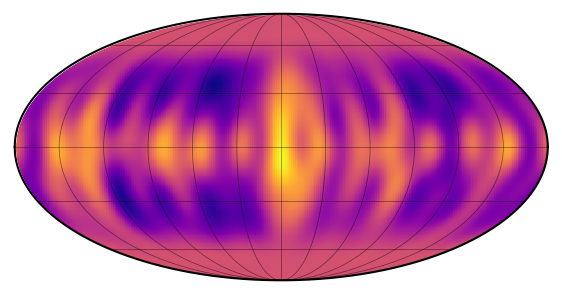

In [86]:
map_inf = starry.Map(15,2)
map_inf[:,:] = np.mean(np.array(sampled_ylms),axis=0).reshape(-1)
map_inf.show(projection='moll')

Text(0, 0.5, 'flux')

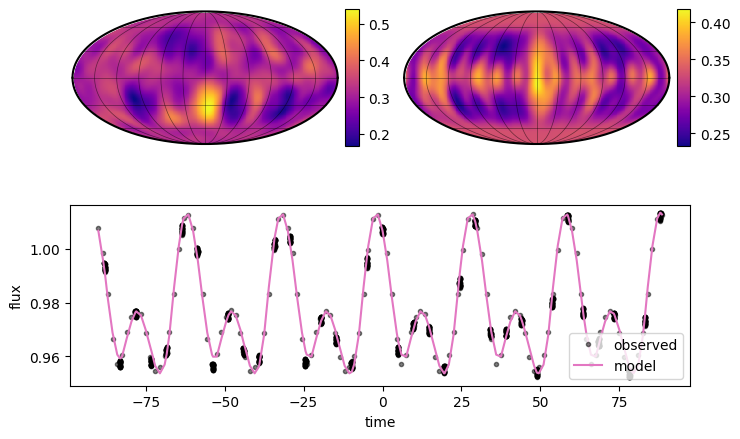

In [94]:
from matplotlib import colors
cmap = plt.get_cmap("plasma")
cmap.set_under("#666666")
cmap.set_over("w")
cnorm = lambda: colors.Normalize(vmin=0.0)
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(wspace=0.15)
ax = [
    plt.subplot2grid((3, 2), (0, 0), colspan=1, rowspan=1),
    plt.subplot2grid((3, 2), (0, 1), colspan=1, rowspan=1),
    plt.subplot2grid((3, 2), (1, 0), colspan=2, rowspan=1),
]

# Show the true map
map_true.show(
    ax=ax[0],
    projection="moll",
    colorbar=True,
)

# Show the inferred map
map_inf.show(
    ax=ax[1],
    projection="moll",
    colorbar=True,
)

# Show the flux model
ax[2].plot(t, flux_obs, "k.", alpha=0.5, label="observed")
ax[2].plot(t, map_inf.flux(theta=theta).eval(), "C6", label="model", alpha=1)
ax[2].legend(fontsize=10, loc="lower right")
ax[2].set_xlabel("time")
ax[2].set_ylabel("flux")

In [83]:
lat=np.linspace(-90., 90., 1000)

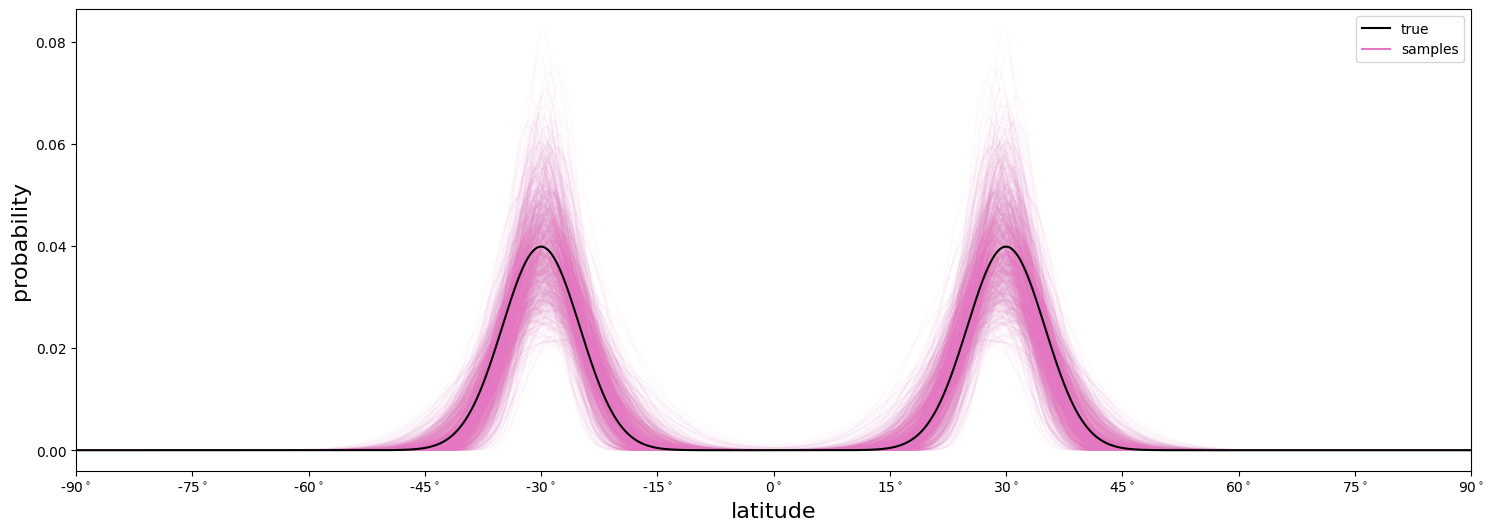

In [84]:
from scipy.stats import norm as Normal

nsamples=1000
fig, ax = plt.subplots(1)
fig.set_size_inches(18, 6)
pdf = 0.5 * (
        Normal.pdf(lat, params['gp.mu']['truth'], params['gp.sigma']['truth'])
        + Normal.pdf(lat, -params['gp.mu']['truth'], params['gp.sigma']['truth'])
    )
for k in range(nsamples):
    ax.plot(lat, 0.5*(Normal.pdf(lat, samples['gp.mu'][0][k], samples['gp.sigma'][0][k])+Normal.pdf(lat, -samples['gp.mu'][0][k], samples['gp.sigma'][0][k])),'C6',lw=1, alpha=0.05, zorder=-1)
ax.plot(lat, pdf,'k',label='true')
ax.plot(lat, np.nan * lat, "C6-", label="samples")
ax.legend(loc="upper right")
ax.set_xlim(-90, 90)
xticks = [-90, -75, -60, -45, -30, -15, 0, 15, 30, 45, 60, 75, 90]
ax.set_xticks(xticks)
ax.set_xticklabels(["{:d}$^\circ$".format(xt) for xt in xticks])
ax.set_xlabel("latitude", fontsize=16)
ax.set_ylabel("probability", fontsize=16)
plt.show()

In [97]:
samples = np.array(samples).T

In [98]:
samples.shape

(22, 1000)

In [100]:
labels = samples_fromfile.posterior.to_dataframe().columns

In [103]:
labels

Index(['star.inc_ori_x', 'star.inc_ori_y', 'star.inc_ori_z', 'star.obl_ori_x',
       'star.obl_ori_y', 'star.obl_ori_z', 'star.protlogp', 'star.prot',
       'star.inc', 'star.obl', 'planet.porblogp', 'planet.porb', 'planet.t0',
       'planet.rlog', 'planet.r', 'b', 'planet.inc', 'gp.mu', 'gp.sigma',
       'gp.r', 'gp.c', 'gp.n'],
      dtype='object')

In [108]:
free

['planet.inc',
 'planet.porb',
 'planet.t0',
 'planet.r',
 'star.inc',
 'star.prot',
 'star.obl',
 'gp.r',
 'gp.c',
 'gp.n',
 'gp.mu',
 'gp.sigma']

In [123]:
# Find the indices of the elements in "labels" that are also present in "free"
indices_to_keep = [i for i, label in enumerate(labels) if label in free]

# Use the indices to filter the rows in "samples"
filtered_samples = samples[indices_to_keep]

In [127]:
free = labels[indices_to_keep]

In [167]:
# saving the true values in a list
truths=[params[x]['truth'] for x in free]

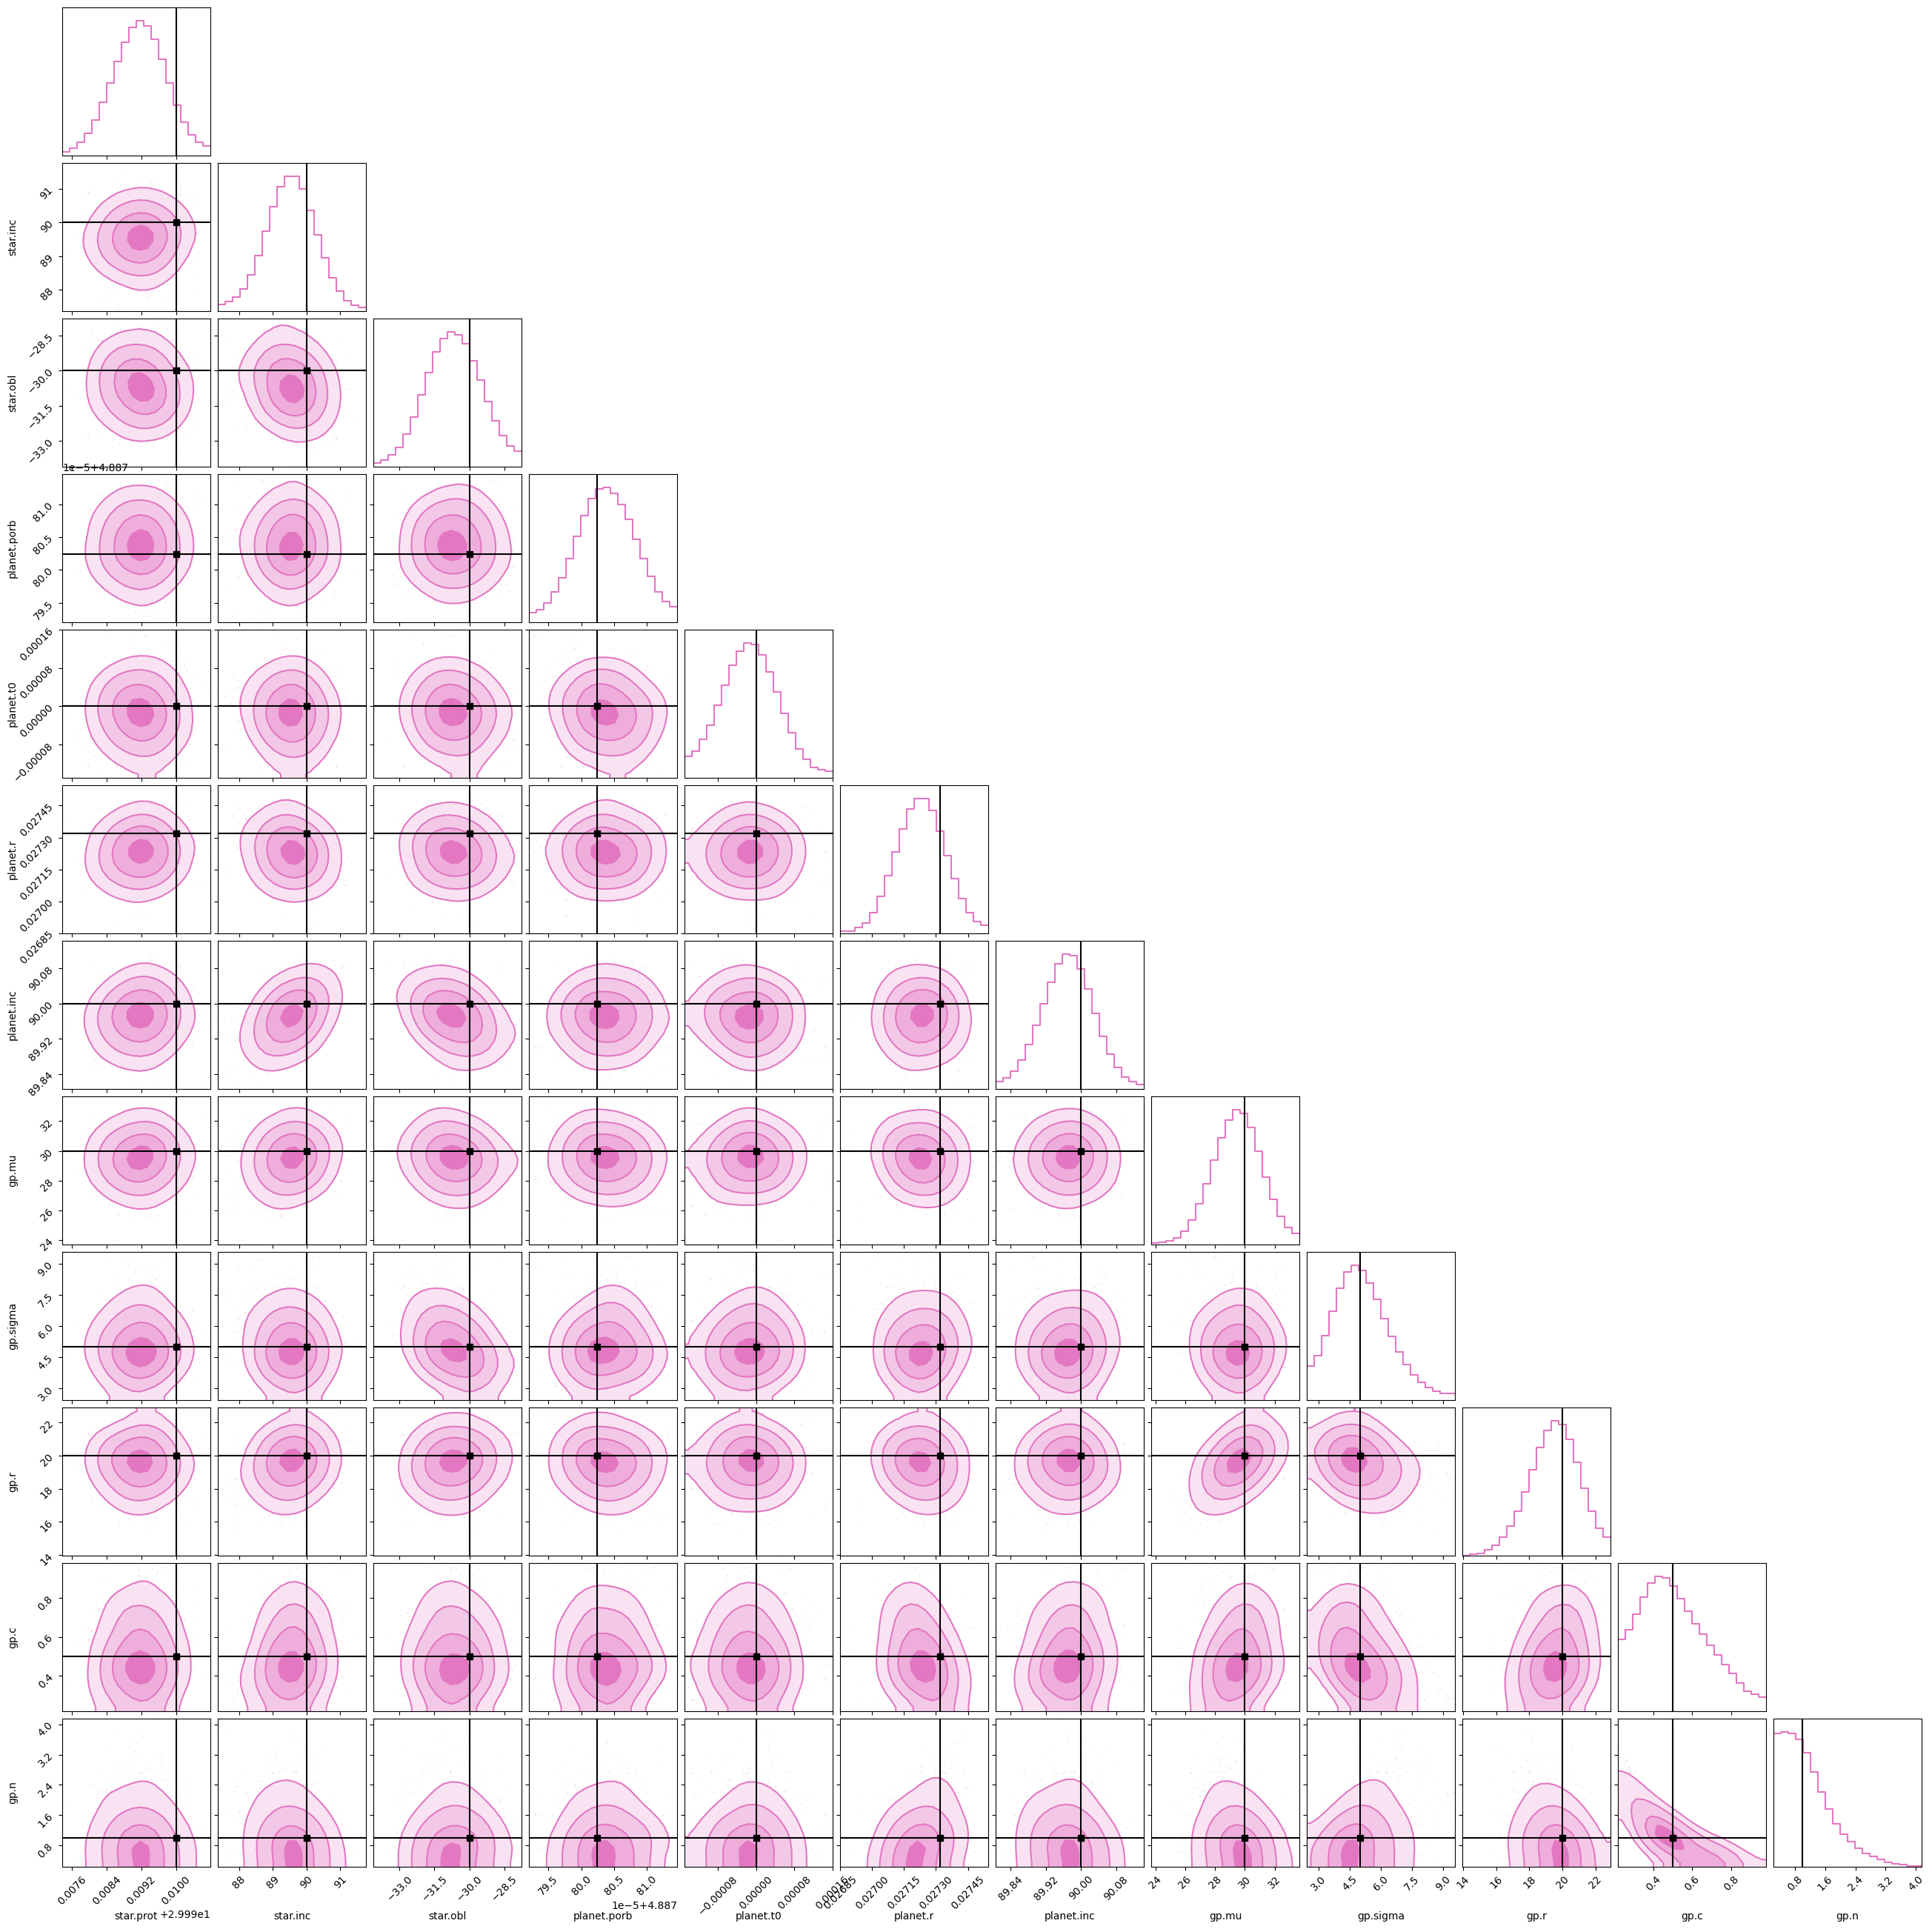

In [177]:
fig = corner(filtered_samples.T,
        labels=free,
        truths=[params[x]['truth'] for x in free], 
        color='C6', 
        truth_color='k',
        plot_datapoints=True,
        plot_density=False,
        fill_contours=True,
        smooth=2.,
        smooth1d=2.,
        hist_kwargs=dict(alpha=1),
        )

/opt/anaconda3/envs/starry-test/lib/python3.8/site-packages/arviz/plots/pairplot.py:242: UserWarning: Divergences data not found, plotting without divergences. Make sure the sample method provides divergences data and that it is present in the `diverging` field of `sample_stats` or `sample_stats_prior` or set divergences=False
  warnings.warn(
/opt/anaconda3/envs/starry-test/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/kdeplot.py:167: UserWarning: The following kwargs were not used by contour: 'color'
  qcfs = ax.contourf(x_x, y_y, density, antialiased=True, **contourf_kwargs)


array([[<Axes: ylabel='gp.mu'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='gp.sigma'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='gp.r'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='gp.c'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='gp.mu', ylabel='gp.n'>, <Axes: xlabel='gp.sigma'>,
        <Axes: xlabel='gp.r'>, <Axes: xlabel='gp.c'>,
        <Axes: xlabel='gp.n'>]], dtype=object)

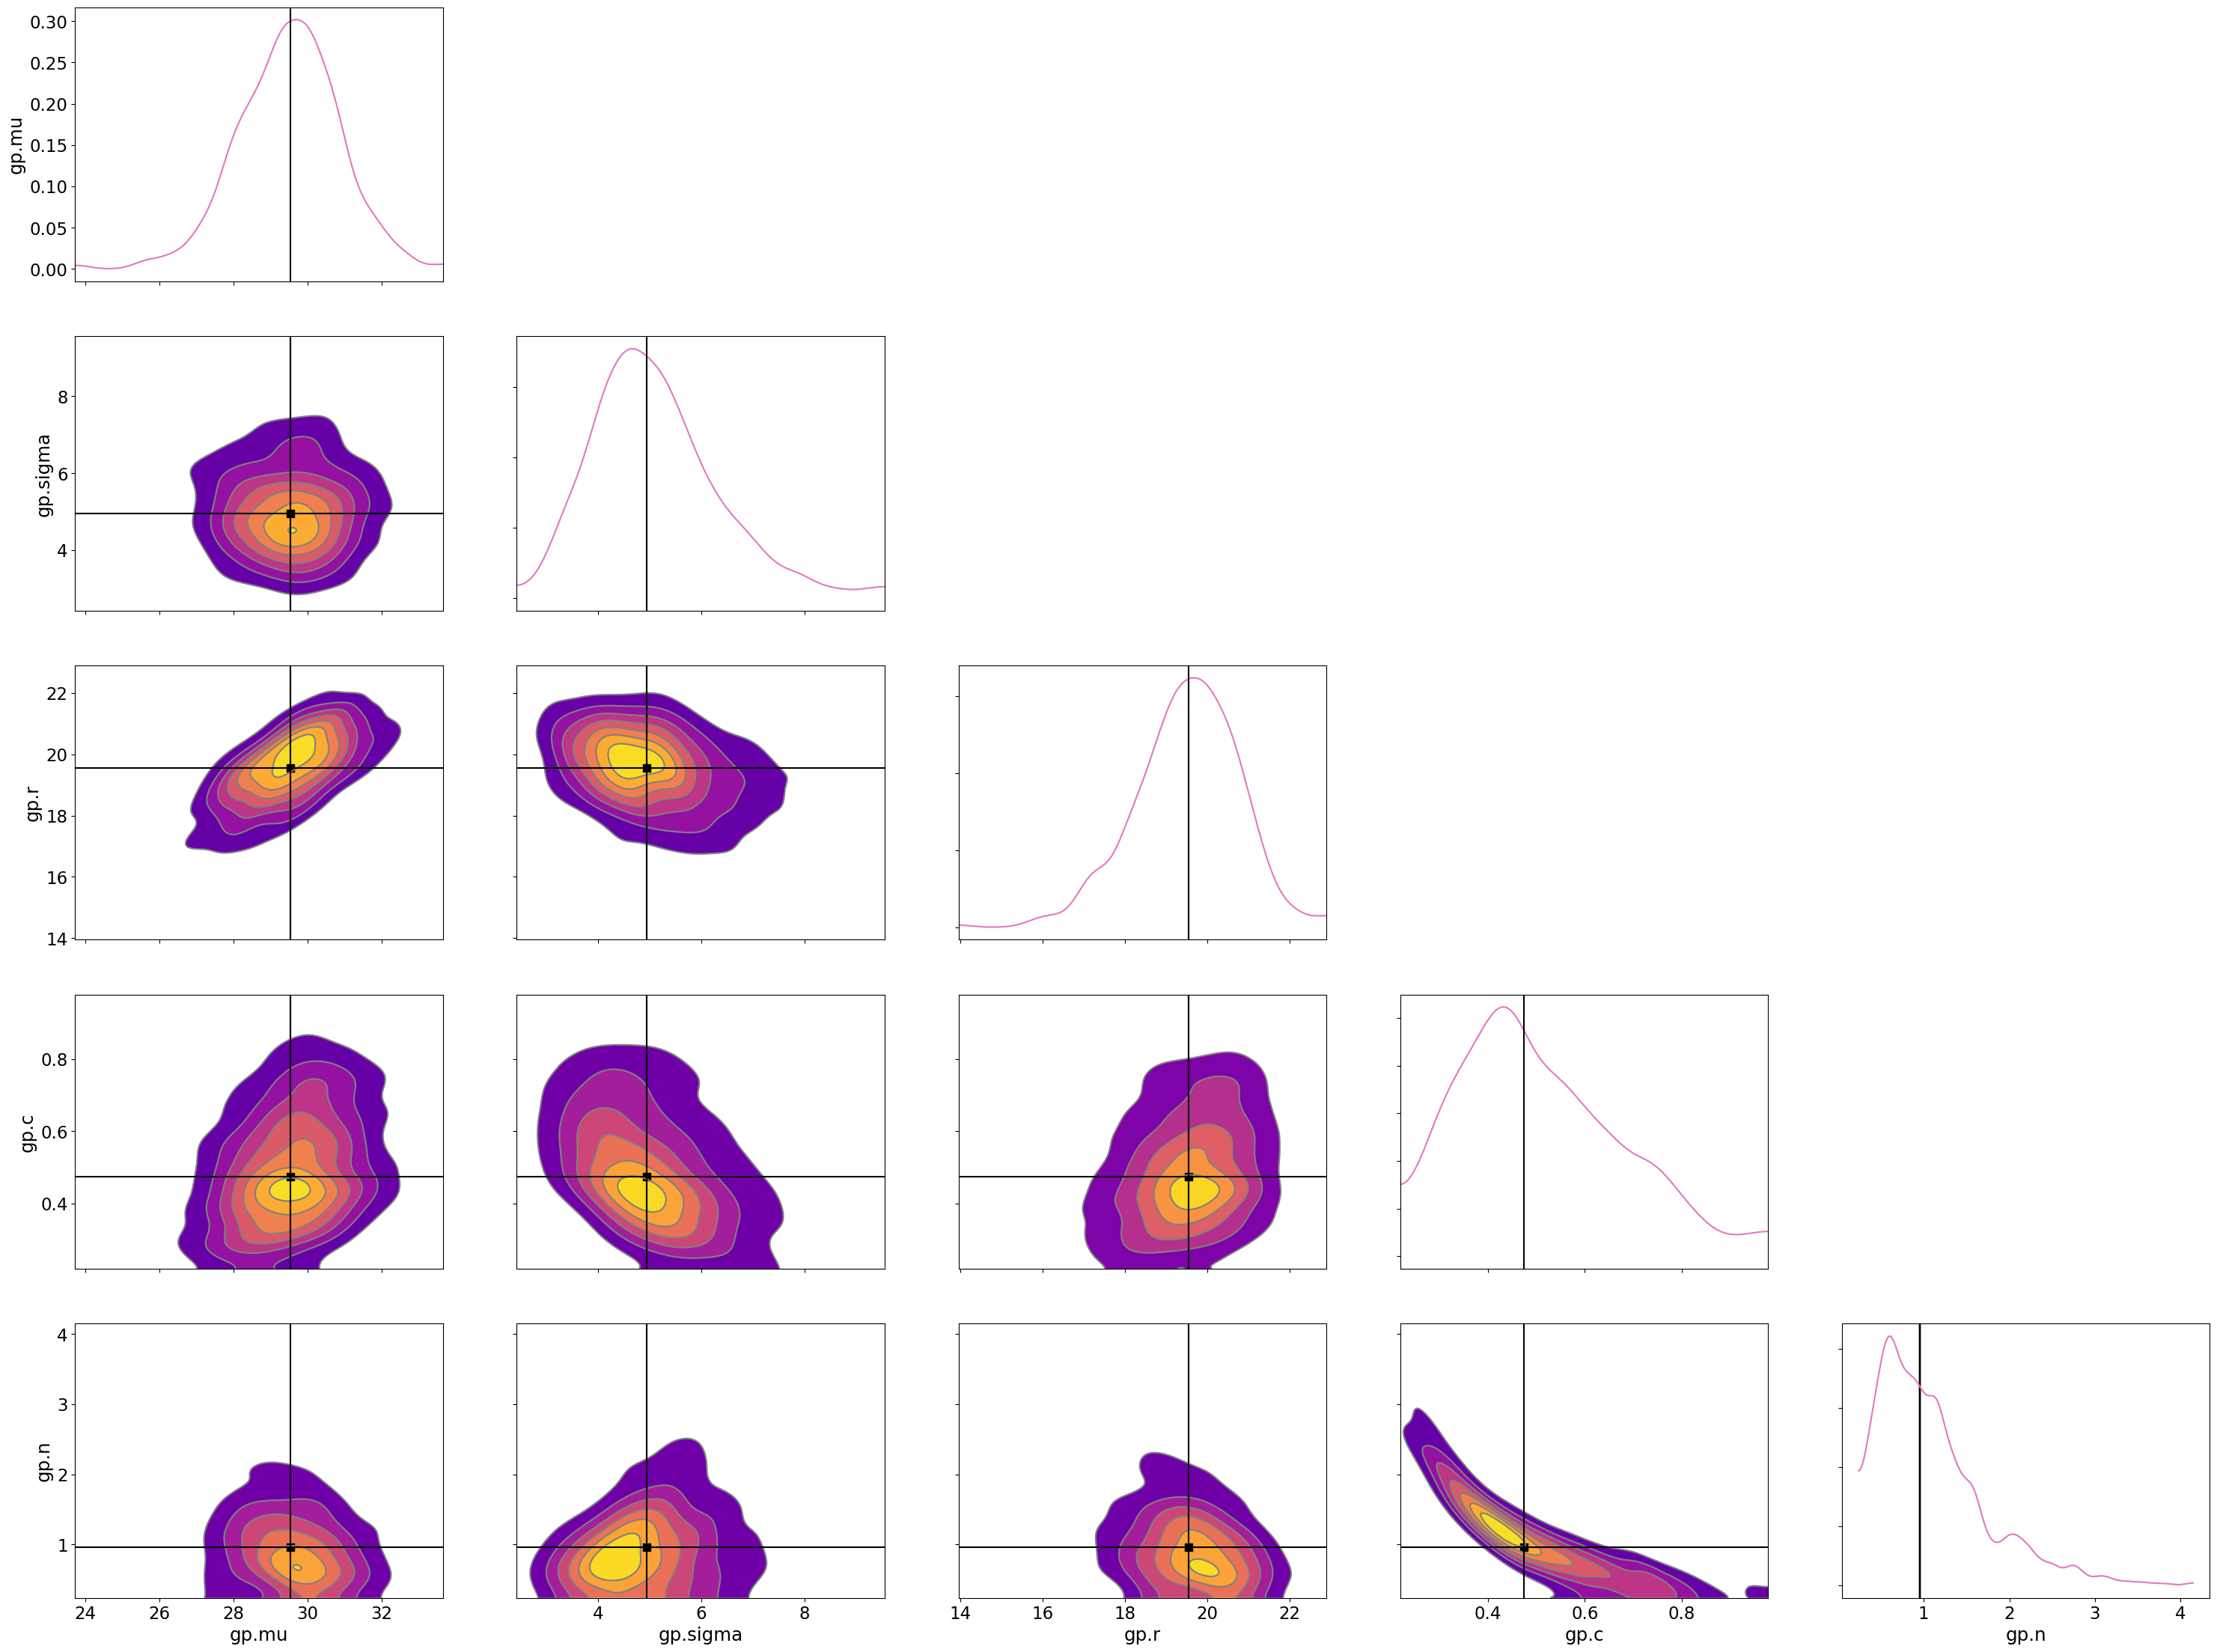

In [102]:
az.plot_pair(
    samples_fromfile.posterior, 
    var_names=['gp.mu', 'gp.sigma', 'gp.r', 'gp.c', 'gp.n'], 
    kind='kde', 
    marginals=True, 
    textsize=16.5, 
    kde_kwargs={'contourf_kwargs':{'color':'C6','cmap':plt.cm.plasma}, 'fill_kwargs':{'alpha': 0.5}},
    divergences=True,
    marginal_kwargs={'color': "C6"},
    point_estimate='median'
    )

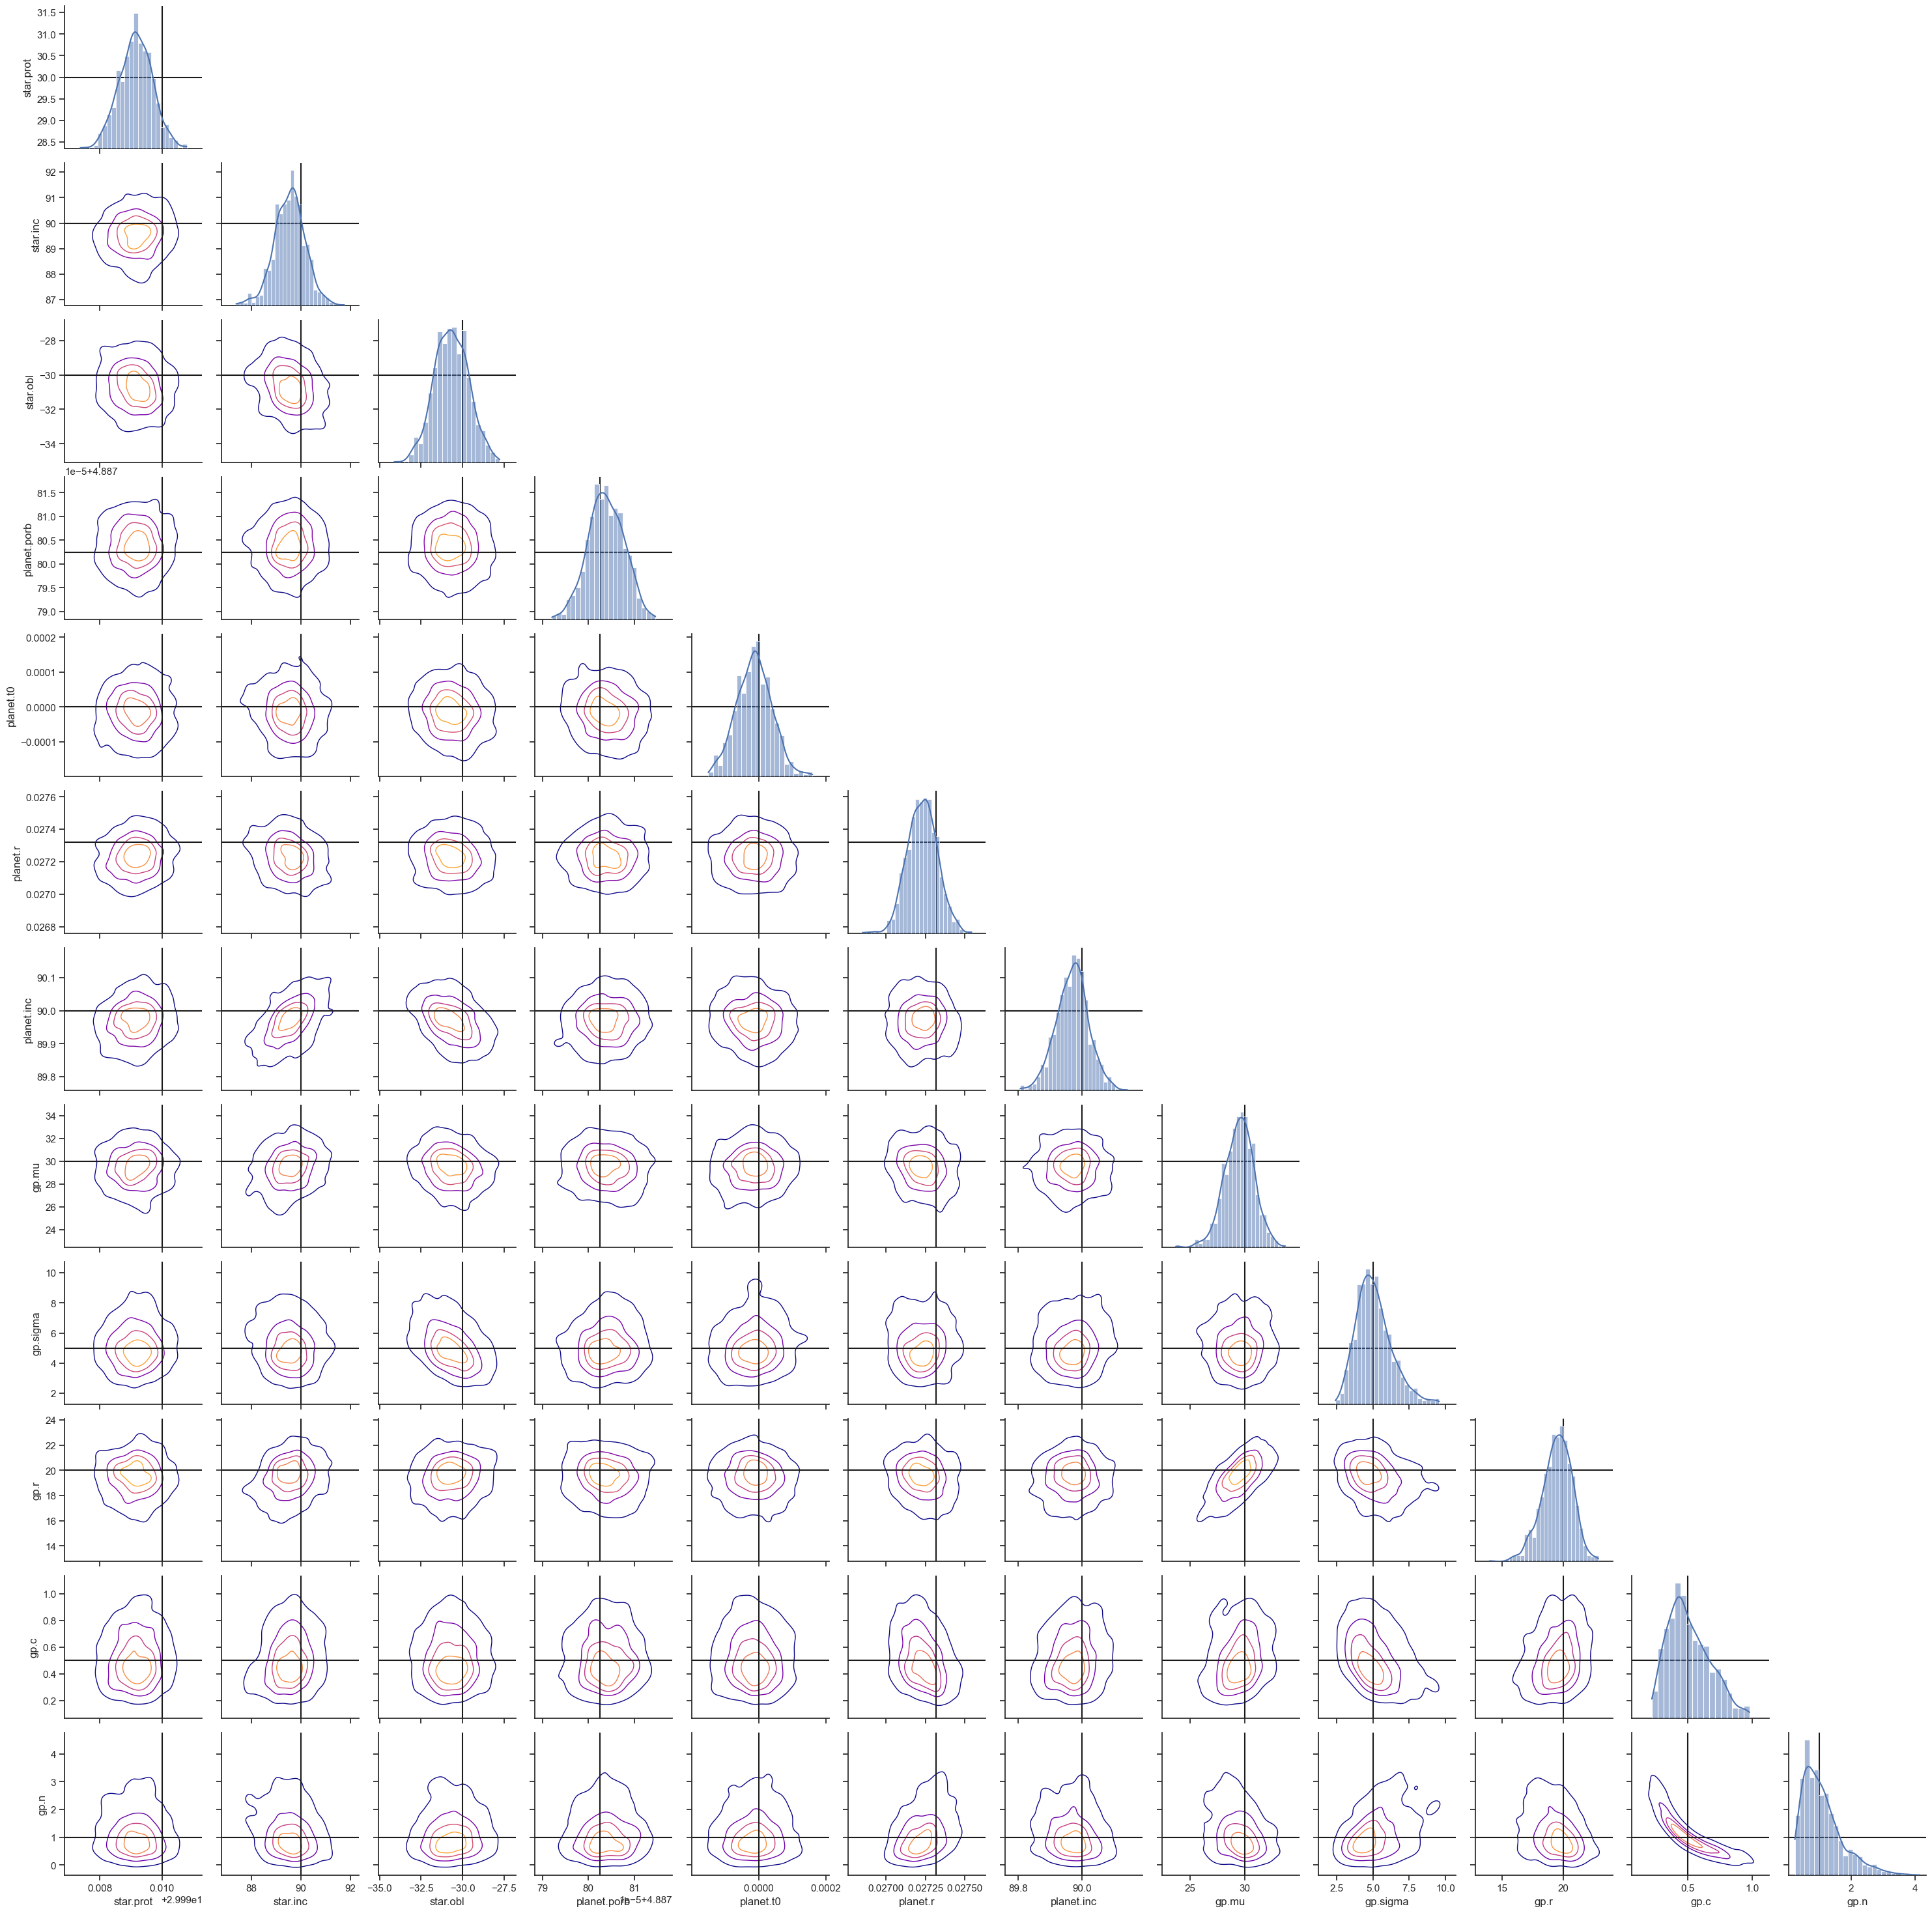

In [191]:
import pandas as pd
import seaborn as sns
df = pd.DataFrame(filtered_samples.T, columns=free)
sns.set(style='ticks')

# Create the pair grid
g = sns.PairGrid(df, diag_sharey=False)

# Map the histograms to the diagonal
g.map_diag(sns.histplot, kde=True)

# Map the 2D contour plots to the lower triangle
g.map_lower(sns.kdeplot, cmap='plasma', levels=5, linewidths=1)

# Custom function to remove upper triangle
def remove_upper(*args, **kwargs):
    plt.gca().axis('off')

# Remove the scatter plots and empty axes in the upper triangle
g.map_upper(remove_upper)

for i, var in enumerate(free):
    truth = params[var]['truth']
    g.axes[i, i].axvline(truth, color='k', linestyle='-')
    g.axes[i, i].axhline(truth, color='k', linestyle='-')

# Add truth values as lines to the contour plots
for i, y_var in enumerate(free):
    for j, x_var in enumerate(free):
        if j < i:
            truth_x = params[x_var]['truth']
            truth_y = params[y_var]['truth']
            g.axes[i, j].axvline(truth_x, color='k', linestyle='-')
            g.axes[i, j].axhline(truth_y, color='k', linestyle='-')
